In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import datasets
import training.train_tabcbm as train_tabcbm
import pandas as pd
import os
from collections import defaultdict
import joblib
import yaml
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from matplotlib import cm
import seaborn as sns
from importlib import reload
from pathlib import Path
import sklearn
import scipy
import metrics
from sklearn.model_selection import train_test_split


In [3]:
def extract_from_name(name, var, default=None):
    if f"{var}=" not in name:
        return default
    start_idx = name.index(f"{var}=")
    end_idx = name.find(",", start_idx)
    if end_idx == -1 and name[-1] != ")":
        # Then we will assume this goes until the end of the string
        end_idx = len(name) + 1
    value = float(name[start_idx + len(f"{var}=") : end_idx])
    if int(value) == float(value):
        value = int(value)
    return value

In [20]:
SYNTH_RESULTS = '/homes/me466/tmp_tabcbm_results/'
datasets_names = [
    ("synth_linear", os.path.join(SYNTH_RESULTS, "tabular_synth/identity_synth")),
    ("synth_nonlin", os.path.join(SYNTH_RESULTS, "tabular_synth/nonlin_synth")),
    ("synth_nonlin_complex", os.path.join(SYNTH_RESULTS, "tabular_synth/nonlin_synth_complex")),
    ("single_cell", os.path.join(SYNTH_RESULTS, "sc_synth/sc_10_cell_types")),
    ("higgs_high_level", "./results/higgs/high_level"),
    ("higgs_no_high_level", "./results/higgs/no_high_level"),
    ("fico", "./results/fico"),
]

models = [
    ("CBM", "Hybrid-CBM"),
    ("vanilla CBM", "CBM"),
    ("CEM", "CEM"),
    ("TabCBM", "TabCBM"),
    ("CCD", "CCD"),
    ("SENN", "SENN"),
    ("TabNet", "TabNet"),
    ("LightGBM", "LightGBM"),
    ("XGBoost", "XGBoost"),
    ("MLP", "MLP"),
    ("PCA", "PCA"),
]

results = {}
selected_metric = 'acc'
force_selection = {
#     ('single_cell', 'TabCBM') : 'TabCBM (k=11, coherence_reg_weight=1, diversity_reg_weight=0.1, feature_selection_reg_weight=1, pretrain_epochs=50, self_supervised_train_epochs=50)',
#     ('single_cell', 'TabCBM') : 'TabCBM (k=11, coherence_reg_weight=0.1, diversity_reg_weight=1, feature_selection_reg_weight=1, pretrain_epochs=50, self_supervised_train_epochs=50)',
#     ('single_cell', 'TabCBM') : 'TabCBM (k=11, coherence_reg_weight=10, diversity_reg_weight=10, feature_selection_reg_weight=10, pretrain_epochs=50, self_supervised_train_epochs=50)',
}

ablation_sc_results = joblib.load(
    os.path.join('/homes/me466/sc_ablation/', "results.joblib")
)

best_selected = defaultdict(lambda: defaultdict(dict))
for dataset_name, ds_path in datasets_names:
    print("Processing dataset", dataset_name)
    full_results = joblib.load(
        os.path.join(ds_path, "results.joblib")
    )
    full_results_real = defaultdict(dict)
    for (cand_model, cand_var), scores in full_results.items():
        full_results_real[cand_model][cand_var] = scores
    results[dataset_name] = defaultdict(lambda: defaultdict(dict))
    for model_name, model_pretty_name in models:
        cands = []
        best_found_score = defaultdict(lambda: -float("inf"))
        best_found_name = {}
        # Find the best performing models
        tmp_selected_metric = selected_metric
#         if model_name.startswith("TabCBM") and ("synth" in dataset_name or dataset_name == "single_cell"):
#             tmp_selected_metric = 'corr_aligned_concept_auc'
        if (dataset_name, model_pretty_name) in force_selection:
            forced_model = force_selection[(dataset_name, model_pretty_name)]
            print("Forcing", forced_model, "for model", model_pretty_name)
#             scores = full_results[(forced_model, tmp_selected_metric)]
            scores = ablation_sc_results[(forced_model, tmp_selected_metric)]
            [(mean, std)] = scores
            c_supervised = extract_from_name(forced_model, "supervised_c", 0)
            p_annotated = extract_from_name(forced_model, "annotated", 0)
            best_found_score[(c_supervised, p_annotated)] = mean
            best_found_name[(c_supervised, p_annotated)] = forced_model
            
            # And save the results 
            for (cand_model, cand_var), scores in ablation_sc_results.items():
                if len(scores) == 1 and (isinstance(scores[0], tuple)):
                    [(mean, std)] = scores
                else:
                    continue
                if not cand_model.startswith(model_name):
                    continue
                c_supervised = extract_from_name(cand_model, "supervised_c", 0)
                p_annotated = extract_from_name(cand_model, "annotated", 0)
                if (c_supervised, p_annotated) not in best_found_name:
                    continue
                if cand_model != best_found_name[(c_supervised, p_annotated)]:
                    continue
                results[dataset_name][model_pretty_name][(c_supervised, p_annotated)][cand_var] = (mean, std)

        else:
            for (cand_model, cand_var), scores in full_results.items():
                if cand_model.startswith('PCA'):
                    if cand_var != "dci_completeness":
                        continue
                elif cand_var != tmp_selected_metric:
                    continue
                if len(scores) == 1 and (isinstance(scores[0], tuple)):
                    [(mean, std)] = scores
    #                 if 'avg_concept_auc' in full_results_real[cand_model]:
    #                     [(other_mean, other_std)] = full_results_real[cand_model]['avg_concept_auc']
    #                     mean = (other_mean + std + mean + other_std )/2
                else:
                    continue
                if (
                    not cand_model.startswith(model_name)
                ):
                    continue
                c_supervised = extract_from_name(cand_model, "supervised_c", 0)
                p_annotated = extract_from_name(cand_model, "annotated", 0)
                if mean > best_found_score[(c_supervised, p_annotated)]:
                    best_found_score[(c_supervised, p_annotated)] = mean
                    best_found_name[(c_supervised, p_annotated)] = cand_model
            # Print them out
            for (c_supervised, p_annotated), name in best_found_name.items():
                if c_supervised != 0:
                    print(
                        "\tBest model for",
                        model_pretty_name,
                        f"(c_supervised={c_supervised} and p_annotated={p_annotated}) was",
                        name, "with score", best_found_score[(c_supervised, p_annotated)]
                    )
                else:
                    print("\tBest model for", model_pretty_name, "was", name)
                best_selected[dataset_name][model_pretty_name][(c_supervised, p_annotated)] = name
            # And save the results 
            for (cand_model, cand_var), scores in full_results.items():
                if len(scores) == 1 and (isinstance(scores[0], tuple)):
                    [(mean, std)] = scores
                else:
                    continue
                if not cand_model.startswith(model_name):
                    continue
                c_supervised = extract_from_name(cand_model, "supervised_c", 0)
                p_annotated = extract_from_name(cand_model, "annotated", 0)
                if (c_supervised, p_annotated) not in best_found_name:
                    continue
                if cand_model != best_found_name[(c_supervised, p_annotated)]:
                    continue
                results[dataset_name][model_pretty_name][(c_supervised, p_annotated)][cand_var] = (mean, std)

Processing dataset synth_linear
	Best model for Hybrid-CBM (c_supervised=1 and p_annotated=0.25) was CBM (k=2, supervised_c=1, annotated=0.25, c_weight=5) with score 0.9506
	Best model for Hybrid-CBM (c_supervised=1 and p_annotated=0.5) was CBM (k=2, supervised_c=1, annotated=0.5, c_weight=5) with score 0.9492666666666667
	Best model for Hybrid-CBM (c_supervised=1 and p_annotated=0.75) was CBM (k=2, supervised_c=1, annotated=0.75, c_weight=5) with score 0.9502
	Best model for Hybrid-CBM (c_supervised=1 and p_annotated=1) was CBM (k=2, supervised_c=1, annotated=1, c_weight=5) with score 0.9538666666666668
	Best model for Hybrid-CBM (c_supervised=2 and p_annotated=0.25) was CBM (k=2, supervised_c=2, annotated=0.25, c_weight=5) with score 0.9487333333333332
	Best model for Hybrid-CBM (c_supervised=2 and p_annotated=0.5) was CBM (k=2, supervised_c=2, annotated=0.5, c_weight=5) with score 0.9531333333333333
	Best model for Hybrid-CBM (c_supervised=2 and p_annotated=0.75) was CBM (k=2, super

	Best model for Hybrid-CBM (c_supervised=1 and p_annotated=0.25) was CBM (k=5, supervised_c=1, annotated=0.25, c_weight=5) with score 0.25566666666666665
	Best model for Hybrid-CBM (c_supervised=1 and p_annotated=0.5) was CBM (k=5, supervised_c=1, annotated=0.5, c_weight=5) with score 0.262
	Best model for Hybrid-CBM (c_supervised=1 and p_annotated=0.75) was CBM (k=5, supervised_c=1, annotated=0.75, c_weight=5) with score 0.2602
	Best model for Hybrid-CBM (c_supervised=1 and p_annotated=1) was CBM (k=5, supervised_c=1, annotated=1, c_weight=5) with score 0.26033333333333336
	Best model for Hybrid-CBM (c_supervised=2 and p_annotated=0.25) was CBM (k=5, supervised_c=2, annotated=0.25, c_weight=5) with score 0.24806666666666666
	Best model for Hybrid-CBM (c_supervised=2 and p_annotated=0.5) was CBM (k=5, supervised_c=2, annotated=0.5, c_weight=5) with score 0.2604666666666667
	Best model for Hybrid-CBM (c_supervised=2 and p_annotated=0.75) was CBM (k=5, supervised_c=2, annotated=0.75, c_w

	Best model for CCD was CCD (k=5)
	Best model for SENN was SENN (k=5)
	Best model for TabNet was TabNet Large & Long
	Best model for LightGBM was LightGBM (d=10, epochs=1500)
	Best model for XGBoost was XGBoost (d=5, epochs=1500)
	Best model for MLP was MLP
	Best model for PCA was PCA
Processing dataset single_cell
	Best model for Hybrid-CBM (c_supervised=1 and p_annotated=0.25) was CBM (k=11, supervised_c=1, annotated=0.25, c_weight=5) with score 0.6654218335706243
	Best model for Hybrid-CBM (c_supervised=1 and p_annotated=0.5) was CBM (k=11, supervised_c=1, annotated=0.5, c_weight=5) with score 0.6730091285001591
	Best model for Hybrid-CBM (c_supervised=1 and p_annotated=0.75) was CBM (k=11, supervised_c=1, annotated=0.75, c_weight=5) with score 0.6663929343196601
	Best model for Hybrid-CBM (c_supervised=1 and p_annotated=1) was CBM (k=11, supervised_c=1, annotated=1, c_weight=5) with score 0.6618056505507168
	Best model for Hybrid-CBM (c_supervised=3 and p_annotated=0.25) was CBM (k

	Best model for CCD was CCD (k=11)
	Best model for SENN was SENN (k=11)
	Best model for TabNet was TabNet Large
	Best model for LightGBM was LightGBM (d=5)
	Best model for XGBoost was XGBoost (d=5, epochs=1500)
	Best model for MLP was MLP
	Best model for PCA was PCA
Processing dataset higgs_high_level
	Best model for TabCBM was TabCBM (smaller k=8, latent=64, w=0.01)
	Best model for CCD was CCD (k=8, lambda1=0.1, lambda2=0.1)
	Best model for SENN was SENN (k=8, pre_train=50, reg=0.1, sparsity=2e-05)
	Best model for TabNet was TabNet small
	Best model for LightGBM was LightGBM (d=10, epochs=1500)
	Best model for XGBoost was XGBoost (d=10, epochs=1500)
	Best model for MLP was MLP
Processing dataset higgs_no_high_level
	Best model for TabCBM was TabCBM (smaller k=8, latent=64, w=0.1)
	Best model for CCD was CCD (k=8, lambda1=0.1, lambda2=0.1)
	Best model for SENN was SENN (k=8, pre_train=50, reg=0.1, sparsity=2e-05)
	Best model for TabNet was TabNet large
	Best model for LightGBM was Ligh

In [21]:
for dataset_name, _ in datasets_names:
    if "MLP" in results[dataset_name]:
#         results[dataset_name]["CBM"][(0, 0)] = results[dataset_name]["MLP"][(0, 0)]
        results[dataset_name]["Hybrid-CBM"][(0, 0)] = results[dataset_name]["MLP"][(0, 0)]

# Mean scores for every dataset

In [22]:
models_to_use = [
    "TabCBM",
    "CCD",
    "SENN",
    "TabNet",
    "LightGBM",
    "XGBoost",
    "MLP",
]

def table_best_results(results, models_to_use, metric, percent=True):
    order = {}
    for ds_name, ds_results in results.items():
        print("Dataset:", ds_name)
        order[ds_name] = {}
        curr_results = []
        for model_name in models_to_use:
            model_results = {}
            if metric in ds_results[model_name]:
                model_results = ds_results[model_name]
            elif (0, 0) in ds_results[model_name]:
                model_results = ds_results[model_name][(0, 0)]

            if metric not in model_results:
                continue
            mean, std = model_results[metric]
            curr_results.append((model_name, mean))

        # Now we actually now the ordering!
        curr_results.sort(key=lambda x: -x[1])
        for i, (model_name, _) in enumerate(curr_results):
            order[ds_name][model_name] = i + 1

        for model_name in models_to_use:
            model_results = {}
            if metric in ds_results[model_name]:
                model_results = ds_results[model_name]
            elif (0, 0) in ds_results[model_name]:
                model_results = ds_results[model_name][(0, 0)]

            if metric not in model_results:
                print("\tSkipping", model_name, "for dataset", ds_name)
                continue
            mean, std = model_results[metric]
            if percent:
                print(f"\t{metric} for", model_name, f"is {mean * 100:.2f}% ± {std * 100:.2f}% (rank = {order[ds_name][model_name]})")
            else:
                print(f"\t{metric} for", model_name, f"is {mean:.2f} ± {std:.2f} (rank = {order[ds_name][model_name]})")

table_best_results(
    results=results,
    models_to_use=models_to_use,
    metric='epochs_trained',
    percent=False,
)

Dataset: synth_linear
	epochs_trained for TabCBM is 1500.00 ± 0.00 (rank = 1)
	epochs_trained for CCD is 1500.00 ± 0.00 (rank = 2)
	Skipping SENN for dataset synth_linear
	epochs_trained for TabNet is 58.00 ± 9.32 (rank = 6)
	epochs_trained for LightGBM is 1500.00 ± 0.00 (rank = 3)
	epochs_trained for XGBoost is 1500.00 ± 0.00 (rank = 4)
	epochs_trained for MLP is 74.80 ± 2.93 (rank = 5)
Dataset: synth_nonlin
	epochs_trained for TabCBM is 1500.00 ± 0.00 (rank = 1)
	epochs_trained for CCD is 1500.00 ± 0.00 (rank = 2)
	Skipping SENN for dataset synth_nonlin
	epochs_trained for TabNet is 181.20 ± 7.11 (rank = 5)
	epochs_trained for LightGBM is 1500.00 ± 0.00 (rank = 3)
	epochs_trained for XGBoost is 1500.00 ± 0.00 (rank = 4)
	epochs_trained for MLP is 65.20 ± 5.27 (rank = 6)
Dataset: synth_nonlin_complex
	epochs_trained for TabCBM is 1500.00 ± 0.00 (rank = 1)
	epochs_trained for CCD is 1500.00 ± 0.00 (rank = 2)
	Skipping SENN for dataset synth_nonlin_complex
	epochs_trained for TabNet is 

In [45]:
Dataset: synth_linear
	Accuracy for TabCBM is 99.84% ± 0.06% (rank = 1)
	Accuracy for CCD is 96.47% ± 1.30% (rank = 6)
	Accuracy for SENN is 98.15% ± 0.20% (rank = 2)
	Accuracy for TabNet is 98.01% ± 0.44% (rank = 3)
	Accuracy for LightGBM is 96.80% ± 0.00% (rank = 5)
	Accuracy for XGBoost is 89.47% ± 0.00% (rank = 7)
	Accuracy for MLP is 97.57% ± 0.37% (rank = 4)
Dataset: synth_nonlin
	Accuracy for TabCBM is 98.36% ± 0.15% (rank = 1)
	Accuracy for CCD is 91.72% ± 1.93% (rank = 7)
	Accuracy for SENN is 95.07% ± 0.30% (rank = 4)
	Accuracy for TabNet is 94.56% ± 0.79% (rank = 5)
	Accuracy for LightGBM is 96.80% ± 0.00% (rank = 2)
	Accuracy for XGBoost is 96.43% ± 0.00% (rank = 3)
	Accuracy for MLP is 93.00% ± 0.50% (rank = 6)
Dataset: synth_nonlin_complex
	Accuracy for TabCBM is 88.00% ± 0.54% (rank = 1)
	Accuracy for CCD is 82.99% ± 1.59% (rank = 3)
	Accuracy for SENN is 82.89% ± 3.19% (rank = 4)
	Accuracy for TabNet is 85.98% ± 1.28% (rank = 2)
	Accuracy for LightGBM is 78.35% ± 0.64% (rank = 5)
	Accuracy for XGBoost is 78.09% ± 0.81% (rank = 6)
	Accuracy for MLP is 62.40% ± 9.96% (rank = 7)
Dataset: single_cell
	Accuracy for TabCBM is 93.66% ± 1.41% (rank = 1)
	Accuracy for CCD is 68.83% ± 1.73% (rank = 7)
	Accuracy for SENN is 78.32% ± 3.03% (rank = 5)
	Accuracy for TabNet is 90.66% ± 1.10% (rank = 2)
	Accuracy for LightGBM is 89.96% ± 1.57% (rank = 4)
	Accuracy for XGBoost is 90.44% ± 1.06% (rank = 3)
	Accuracy for MLP is 73.87% ± 1.43% (rank = 6)
Dataset: higgs_high_level
	Accuracy for TabCBM is 78.62% ± 0.12% (rank = 1)
	Accuracy for CCD is 77.92% ± 0.09% (rank = 4)
	Accuracy for SENN is 73.53% ± 0.71% (rank = 7)
	Accuracy for TabNet is 78.12% ± 0.05% (rank = 3)
	Accuracy for LightGBM is 75.33% ± 0.03% (rank = 6)
	Accuracy for XGBoost is 75.33% ± 0.04% (rank = 5)
	Accuracy for MLP is 78.44% ± 0.02% (rank = 2)
Dataset: higgs_no_high_level
	Accuracy for TabCBM is 80.42% ± 0.30% (rank = 1)
	Accuracy for CCD is 77.84% ± 0.08% (rank = 4)
	Accuracy for SENN is 70.61% ± 0.12% (rank = 5)
	Accuracy for TabNet is 79.44% ± 0.16% (rank = 3)
	Accuracy for LightGBM is 68.87% ± 0.06% (rank = 6)
	Accuracy for XGBoost is 68.85% ± 0.02% (rank = 7)
	Accuracy for MLP is 79.90% ± 0.15% (rank = 2)
Dataset: fico
	Accuracy for TabCBM is 71.37% ± 0.80% (rank = 3)
	Accuracy for CCD is 65.09% ± 4.07% (rank = 7)
	Accuracy for SENN is 66.78% ± 0.69% (rank = 6)
	Accuracy for TabNet is 71.20% ± 0.87% (rank = 4)
	Accuracy for LightGBM is 72.63% ± 0.12% (rank = 1)
	Accuracy for XGBoost is 72.33% ± 0.44% (rank = 2)
	Accuracy for MLP is 67.98% ± 1.36% (rank = 5)

IndentationError: unexpected indent (975765482.py, line 2)

# Plot Concept Supervised performance

In [23]:
def make_concept_sup_plot(
    all_models,
    ds_name,
    ax,
    num_concepts,
    data_percent_annotations,
    y_start=None,
    y_end=None, #100,
    y_delta=0, #10,
    y_label="Accuracy (%)",
    line_style_map=None,
    marker_style_map=None,
    hatch_style_map=None,
    color_map=None,
    font=20,
    line_styles=["solid", "dashed", "dotted", "dashdot"],
    marker_styles=["o", "x", "s", "d"],
    hatch_styles=["/", "\\", "|", "o"],
    x_label="# of training concepts",
    shift=False,
    clrs=sns.color_palette("pastel", 5),
    alpha=0.1,
    default_mean=None,
):
    if line_style_map is None:
        line_style_map = {}
    if marker_style_map is None:
        marker_style_map = {}
    if hatch_style_map is None:
        hatch_style_map = {}
    if color_map is None:
        color_map = {}
    num_models = len(all_models) + 1
    legend_plots = []
    legend_names = []
    for i, (method_name, current_results, kword, transform_fn) in enumerate(all_models):
        for p_annotated in data_percent_annotations:
            if 0 in data_percent_annotations or 0 in num_concepts:
                if kword not in current_results[method_name][(0, 0)]:
                    if default_mean is not None:
                        mean = default_mean
                        std = 0
                    else:
                        mean = std = None
                else:
                    mean, std = current_results[method_name][(0, 0)][kword]
                if mean is not None:
                    y_means = [transform_fn(mean)]
                    y_stds = [transform_fn(std)]
                else:
                    y_means, y_stds = [], []
            else:
                y_means, y_stds = [], []
            for c_supervised in num_concepts:
                if (c_supervised, p_annotated) not in current_results[method_name] or (c_supervised == 0):
                    # Then we will not make a plot for this
                    continue
                if default_mean is not None and kword not in current_results[method_name][(c_supervised, p_annotated)]:
                    mean = default_mean
                    std = 0
                else:
                    mean, std = current_results[method_name][(c_supervised, p_annotated)][kword]
                mean = transform_fn(mean)
                std = transform_fn(std)
                y_stds.append(std)
                y_means.append(mean)

            if len(y_means):
                key = method_name #p_annotated
                if key not in line_style_map:
                    line_style_map[key] = line_styles[len(line_style_map) % len(line_styles)]
                line_style = line_style_map[key]
                
                if key not in marker_style_map:
                    marker_style_map[key] = marker_styles[len(marker_style_map) % len(marker_styles)]
                marker_style = marker_style_map[key]
                
                if key not in hatch_style_map:
                    hatch_style_map[key] = hatch_styles[len(hatch_style_map) % len(hatch_styles)]
                hatch_style = hatch_style_map[key]
                
                key = method_name # (method_name, p_annotated)
                if key not in color_map:
                    color_map[key] = clrs[len(color_map)]
                color = color_map[key]
                y_means = np.array(y_means)
                y_stds = np.array(y_stds)
                
                x_vals = np.arange(int(shift), len(num_concepts) + int(shift))
                if len(x_vals) > len(y_means):
                    x_vals = x_vals[-len(y_means):]
                p1 = ax.plot(
                    x_vals,
                    y_means,
                    color=color,
                    linestyle=line_style,
                    marker=marker_style,
                )
                ax.fill_between(
                    x_vals,
                    y_means -  2*y_stds,
                    y_means + 2*y_stds,
                    color=color,
                    alpha=alpha,
                    hatch=hatch_style,
                )
                p2 = ax.fill(np.NaN, np.NaN, color=color, hatch=hatch_style, alpha=alpha)
                legend_plots.append((p2[0], p1[0]))
                legend_names.append(f"{method_name}")
            else:
                print("Skipping", method_name)

    if y_label:
        ax.set_ylabel(
            y_label.format(c_supervised=c_supervised, p_annotated=int(p_annotated * 100)),
            fontsize=int(font*0.8)
        )
    if x_label:
        ax.set_xlabel(
            x_label.format(c_supervised=c_supervised, p_annotated=int(p_annotated * 100)),
            fontsize=int(font*0.8),
        )
    if ds_name:
        ax.set_title(ds_name, fontsize=font)
    
    ax.set_xticks(np.arange(int(shift), len(num_concepts) + int(shift)))
    ax.set_xlim((0, len(num_concepts) - 1  + (2 if shift else 0.5)))
    ax.set_xticklabels(list(map(lambda x: f"{x}",num_concepts)), fontsize=int(font * 0.7))
    if (y_start is not None) and (y_end is not None):
        ax.set_yticks(np.arange(y_start, y_end + y_delta, y_delta))
        ax.set_ylim((y_start - y_delta, y_end + y_delta))
        ax.set_yticklabels(list(map(lambda x: f"{x}", np.arange(y_start, y_end + y_delta, y_delta))), fontsize=int(font * 0.7))
    else:
        ax.tick_params(axis='y', labelsize=int(font * 0.7))
    ax.grid(False)
    return legend_plots, legend_names

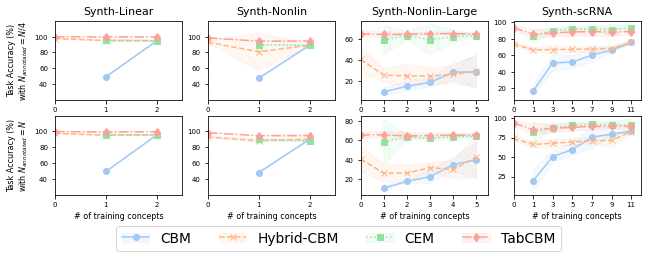

In [27]:
# Plot concept accuracies for all methods
# Set up our figure
p_annotations = [0.25, 1] #[0.25, 0.5, 0.75, 1]
color_map = {}
line_style_map = {}
marker_style_map = {}
hatch_style_map = {}
font = 11
fig_width = 10.5
fig_height = 1.6 * len(p_annotations)
fig, axs = plt.subplots(len(p_annotations), 4, figsize=(fig_width, fig_height))
metric = "acc"
handles = []
labels = []



for i, p_annotation in enumerate(p_annotations):
    new_handles, new_labels = make_concept_sup_plot(
        num_concepts=np.arange(3),
        data_percent_annotations=[p_annotation],
        all_models=[
            (
                "CBM",
                results["synth_linear"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "Hybrid-CBM",
                results["synth_linear"],
                metric,
                lambda x: 100 * x,
            ),
            (
                'CEM',
                results["synth_linear"],
                metric,
                lambda x: 100 * x,
                
            ),
            (
                "TabCBM",
                results["synth_linear"],
                metric,
                lambda x: 100 * x,
            ),
        ],
        ds_name="Synth-Linear" if i == 0 else "",
        ax=axs[i, 0],
        y_start=40, #96,
        y_end=100,
        y_delta=20, #0.5,
        y_label=(
            "Task Accuracy (%)\nwith $N_{{annotated}} = N/4$" if p_annotation == 0.25
            else "Task Accuracy (%)\nwith $N_{{annotated}} = N$"
        ),
        x_label="# of training concepts" if i == len(p_annotations) - 1 else "",
        line_style_map=line_style_map,
        marker_style_map=marker_style_map,
        hatch_style_map=hatch_style_map,
        color_map=color_map,
        font=font,
    )
    for handle, lbl in zip(new_handles, new_labels):
        if lbl not in labels:
            labels.append(lbl)
            handles.append(handle)

    new_handles, new_labels = make_concept_sup_plot(
        num_concepts=np.arange(3),
        data_percent_annotations=[p_annotation],
        all_models=[
            (
                "CBM",
                results["synth_nonlin"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "Hybrid-CBM",
                results["synth_nonlin"],
                metric,
                lambda x: 100 * x,
            ),
            (
                'CEM',
                results["synth_nonlin"],
                metric,
                lambda x: 100 * x,
                
            ),
            (
                "TabCBM",
                results["synth_nonlin"],
                metric,
                lambda x: 100 * x,
            ),
        ],
        ds_name="Synth-Nonlin" if i == 0 else "",
        ax=axs[i, 1],
        y_start=40, #96,
        y_end=100,
        y_delta=20, #0.5,
        y_label="",
        x_label="# of training concepts" if i == len(p_annotations) - 1 else "",
        line_style_map=line_style_map,
        marker_style_map=marker_style_map,
        hatch_style_map=hatch_style_map,
        color_map=color_map,
        font=font,
    )
    for handle, lbl in zip(new_handles, new_labels):
        if lbl not in labels:
            labels.append(lbl)
            handles.append(handle)

    new_handles, new_labels = make_concept_sup_plot(
        num_concepts=np.arange(0, 6),
        data_percent_annotations=[p_annotation],
        all_models=[
            (
                "CBM",
                results["synth_nonlin_complex"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "Hybrid-CBM",
                results["synth_nonlin_complex"],
                metric,
                lambda x: 100 * x,
            ),
            (
                'CEM',
                results["synth_nonlin_complex"],
                metric,
                lambda x: 100 * x,
                
            ),
            (
                "TabCBM",
                results["synth_nonlin_complex"],
                metric,
                lambda x: 100 * x,
            ),
        ],
        ds_name="Synth-Nonlin-Large" if i == 0 else "",
        ax=axs[i, 2],
#         y_start=20,
#         y_end=70,
#         y_delta=10,
        y_label="",
        x_label="# of training concepts" if i == len(p_annotations) - 1 else "",
        line_style_map=line_style_map,
        marker_style_map=marker_style_map,
        hatch_style_map=hatch_style_map,
        color_map=color_map,
        font=font,
    )
    for handle, lbl in zip(new_handles, new_labels):
        if lbl not in labels:
            labels.append(lbl)
            handles.append(handle)


    new_handles, new_labels = make_concept_sup_plot(
        num_concepts=[0, 1, 3, 5, 7, 9, 11],
        data_percent_annotations=[p_annotation],
        all_models=[
            (
                "CBM",
                results["single_cell"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "Hybrid-CBM",
                results["single_cell"],
                metric,
                lambda x: 100 * x,
            ),
            (
                'CEM',
                results["single_cell"],
                metric,
                lambda x: 100 * x,
                
            ),
            (
                "TabCBM",
                results["single_cell"],
                metric,
                lambda x: 100 * x,
            ),
        ],
        ds_name="Synth-scRNA" if i == 0 else "",
        ax=axs[i, 3],
#         y_start=60,
#         y_end=100,
#         y_delta=5,
        y_label="",
        x_label="# of training concepts" if i == len(p_annotations) - 1 else "",
        line_style_map=line_style_map,
        marker_style_map=marker_style_map,
        hatch_style_map=hatch_style_map,
        color_map=color_map,
        font=font,
    )
    for handle, lbl in zip(new_handles, new_labels):
        if lbl not in labels:
            labels.append(lbl)
            handles.append(handle)


# handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(
    handles,
    labels,
    fontsize=font*1.25,
    loc='upper center',
    bbox_to_anchor=(0.5,0.02),
    ncol=4,
)

plt.savefig(
    os.path.join(
        "figures/",
        "concept_supervision_task_acc.png",
    ),
    bbox_extra_artists=(lgd,),
    bbox_inches='tight'
)
plt.savefig(
    os.path.join(
        "figures/",
        "concept_supervision_task_acc.pdf",
    ),
    bbox_extra_artists=(lgd,),
    bbox_inches='tight'
)
plt.show()

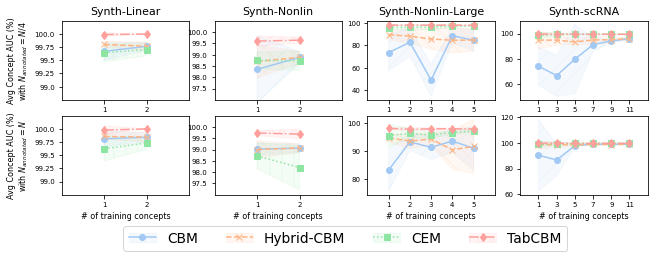

In [26]:
# Plot concept accuracies for all methods
# Set up our figure

p_annotations = [0.25, 1] #[0.25, 0.5, 0.75, 1]
color_map = {}
line_style_map = {}
marker_style_map = {}
hatch_style_map = {}
font = 11
fig_width = 10.5
fig_height = 1.6 * len(p_annotations)
fig, axs = plt.subplots(len(p_annotations), 4, figsize=(fig_width, fig_height))
metric = "avg_concept_auc"
handles = []
labels = []



for i, p_annotation in enumerate(p_annotations):
    new_handles, new_labels = make_concept_sup_plot(
        num_concepts=np.arange(1, 3),
        data_percent_annotations=[p_annotation],
        all_models=[
            (
                "CBM",
                results["synth_linear"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "Hybrid-CBM",
                results["synth_linear"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "CEM",
                results["synth_linear"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "TabCBM",
                results["synth_linear"],
                metric,
                lambda x: 100 * x,
            ),
        ],
        ds_name="Synth-Linear" if i == 0 else "",
        ax=axs[i, 0],
        y_start=99,
        y_end=100,
        y_delta=0.25,
        y_label=(
            "Avg Concept AUC (%)\nwith $N_{{annotated}} = N/4$" if p_annotation == 0.25
            else "Avg Concept AUC (%)\nwith $N_{{annotated}} = N$"
        ),
        x_label="# of training concepts" if i == len(p_annotations) - 1 else "",
        line_style_map=line_style_map,
        marker_style_map=marker_style_map,
        hatch_style_map=hatch_style_map,
        color_map=color_map,
        font=font,
        shift=True,
    )
    for handle, lbl in zip(new_handles, new_labels):
        if lbl not in labels:
            labels.append(lbl)
            handles.append(handle)

    new_handles, new_labels = make_concept_sup_plot(
        num_concepts=np.arange(1, 3),
        data_percent_annotations=[p_annotation],
        all_models=[
            (
                "CBM",
                results["synth_nonlin"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "Hybrid-CBM",
                results["synth_nonlin"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "CEM",
                results["synth_nonlin"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "TabCBM",
                results["synth_nonlin"],
                metric,
                lambda x: 100 * x,
            ),
        ],
        ds_name="Synth-Nonlin" if i == 0 else "",
        ax=axs[i, 1],
        y_start=97.5,
        y_end=100,
        y_delta=0.5,
        y_label="",
        x_label="# of training concepts" if i == len(p_annotations) - 1 else "",
        line_style_map=line_style_map,
        marker_style_map=marker_style_map,
        hatch_style_map=hatch_style_map,
        color_map=color_map,
        font=font,
        shift=True,
    )
    for handle, lbl in zip(new_handles, new_labels):
        if lbl not in labels:
            labels.append(lbl)
            handles.append(handle)

    new_handles, new_labels = make_concept_sup_plot(
        num_concepts=np.arange(1, 6),
        data_percent_annotations=[p_annotation],
        all_models=[
            (
                "CBM",
                results["synth_nonlin_complex"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "Hybrid-CBM",
                results["synth_nonlin_complex"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "CEM",
                results["synth_nonlin_complex"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "TabCBM",
                results["synth_nonlin_complex"],
                metric,
                lambda x: 100 * x,
            ),
        ],
        ds_name="Synth-Nonlin-Large" if i == 0 else "",
        ax=axs[i, 2],
#         y_start=20,
#         y_end=100,
#         y_delta=20,
        y_label="",
        x_label="# of training concepts" if i == len(p_annotations) - 1 else "",
        line_style_map=line_style_map,
        marker_style_map=marker_style_map,
        hatch_style_map=hatch_style_map,
        color_map=color_map,
        font=font,
        shift=True,
    )
    for handle, lbl in zip(new_handles, new_labels):
        if lbl not in labels:
            labels.append(lbl)
            handles.append(handle)


    new_handles, new_labels = make_concept_sup_plot(
        num_concepts=[1, 3, 5, 7, 9, 11],
        data_percent_annotations=[p_annotation],
        all_models=[
            (
                "CBM",
                results["single_cell"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "Hybrid-CBM",
                results["single_cell"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "CEM",
                results["single_cell"],
                metric,
                lambda x: 100 * x,
            ),
            (
                "TabCBM",
                results["single_cell"],
                metric,
                lambda x: 100 * x,
            ),
        ],
        ds_name="Synth-scRNA" if i == 0 else "",
        ax=axs[i, 3],
#         y_start=20,
#         y_end=100,
#         y_delta=20,
        y_label="",
        x_label="# of training concepts" if i == len(p_annotations) - 1 else "",
        line_style_map=line_style_map,
        marker_style_map=marker_style_map,
        hatch_style_map=hatch_style_map,
        color_map=color_map,
        font=font,
        shift=True,
    )
    for handle, lbl in zip(new_handles, new_labels):
        if lbl not in labels:
            labels.append(lbl)
            handles.append(handle)


# handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(
    handles,
    labels,
    fontsize=font*1.25,
    loc='upper center',
    bbox_to_anchor=(0.5,0.02),
    ncol=4,
)


plt.savefig(
    os.path.join(
        "figures/",
        "concept_supervision_avg_concept_auc.pdf",
    ),
    bbox_extra_artists=(lgd,),
    bbox_inches='tight'
)
plt.show()

# Average Metric Computation

In [28]:
metrics_to_use = [
    "cas",
    "sap",
    "mig",
    "r4",
    "dci_disentanglement",
    "dci_informativeness",
    "dci_completeness",
]

models_to_use = [
    "SENN",
    "CCD",
    "TabCBM",
    "PCA",
]
values = defaultdict(list)
rankings = defaultdict(lambda: defaultdict(list))

for dataset_name, ds_results in results.items():
#     if dataset_name != "single_cell":
#         continue
    tmp_rankings = defaultdict(list)
    for model_name in models_to_use:
        if (
            ((0, 0) not in ds_results[model_name])
        ):
            continue
        print(dataset_name, model_name)
        ds_and_model_results = ds_results[model_name][(0, 0)]
        for metric_name in metrics_to_use:
            if metric_name not in ds_and_model_results:
                print("Skipping for", model_name, metric_name)
                print(ds_and_model_results)
                continue
            values[(model_name, metric_name)].append(ds_and_model_results[metric_name][0])
            tmp_rankings[metric_name].append((model_name, ds_and_model_results[metric_name][0]))
    for metric_name, vals in tmp_rankings.items():
        ranks_in_ds = list(enumerate(map(
            lambda x: x[0],
            sorted(vals, key=lambda x: -x[1]),
        )))
        for rank, method_name in ranks_in_ds:
            print(dataset_name, metric_name, method_name, rank + 1)
            rankings[metric_name][method_name].append(rank + 1)
ranking_means = {}
print(rankings)
for metric_name, inner_ranks in rankings.items():
    for method_name, ranks in inner_ranks.items():
        ranking_means[(method_name, metric_name)] = (np.mean(ranks), np.std(ranks))

synth_linear SENN
synth_linear CCD
synth_linear TabCBM
synth_linear PCA
synth_linear cas TabCBM 1
synth_linear cas CCD 2
synth_linear cas SENN 3
synth_linear cas PCA 4
synth_linear sap TabCBM 1
synth_linear sap CCD 2
synth_linear sap SENN 3
synth_linear sap PCA 4
synth_linear mig TabCBM 1
synth_linear mig CCD 2
synth_linear mig SENN 3
synth_linear mig PCA 4
synth_linear r4 TabCBM 1
synth_linear r4 CCD 2
synth_linear r4 SENN 3
synth_linear r4 PCA 4
synth_linear dci_disentanglement TabCBM 1
synth_linear dci_disentanglement CCD 2
synth_linear dci_disentanglement PCA 3
synth_linear dci_disentanglement SENN 4
synth_linear dci_informativeness TabCBM 1
synth_linear dci_informativeness CCD 2
synth_linear dci_informativeness SENN 3
synth_linear dci_informativeness PCA 4
synth_linear dci_completeness TabCBM 1
synth_linear dci_completeness PCA 2
synth_linear dci_completeness CCD 3
synth_linear dci_completeness SENN 4
synth_nonlin SENN
synth_nonlin CCD
synth_nonlin TabCBM
synth_nonlin PCA
synth_no

In [29]:
for metric_name, (mean, std) in ranking_means.items():
    print(f"{metric_name} = {mean:.2f} $\pm$ {std:.2f}")

('TabCBM', 'cas') = 1.50 $\pm$ 0.87
('CCD', 'cas') = 3.00 $\pm$ 1.00
('SENN', 'cas') = 2.75 $\pm$ 0.43
('PCA', 'cas') = 2.75 $\pm$ 1.30
('TabCBM', 'sap') = 1.75 $\pm$ 0.83
('CCD', 'sap') = 1.75 $\pm$ 0.43
('SENN', 'sap') = 3.50 $\pm$ 0.50
('PCA', 'sap') = 3.00 $\pm$ 1.22
('TabCBM', 'mig') = 1.50 $\pm$ 0.87
('CCD', 'mig') = 2.00 $\pm$ 0.00
('SENN', 'mig') = 3.50 $\pm$ 0.50
('PCA', 'mig') = 3.00 $\pm$ 1.22
('TabCBM', 'r4') = 1.50 $\pm$ 0.87
('CCD', 'r4') = 2.00 $\pm$ 0.00
('SENN', 'r4') = 3.50 $\pm$ 0.50
('PCA', 'r4') = 3.00 $\pm$ 1.22
('TabCBM', 'dci_disentanglement') = 1.50 $\pm$ 0.87
('CCD', 'dci_disentanglement') = 2.00 $\pm$ 0.00
('PCA', 'dci_disentanglement') = 3.00 $\pm$ 1.22
('SENN', 'dci_disentanglement') = 3.50 $\pm$ 0.50
('TabCBM', 'dci_informativeness') = 1.75 $\pm$ 0.83
('CCD', 'dci_informativeness') = 2.25 $\pm$ 1.09
('SENN', 'dci_informativeness') = 3.00 $\pm$ 0.71
('PCA', 'dci_informativeness') = 3.00 $\pm$ 1.22
('TabCBM', 'dci_completeness') = 1.50 $\pm$ 0.87
('PCA', 'dc

In [ ]:
('PCA', 'cas') = 2.75 ± 1.299038105676658
('PCA', 'sap') = 3.0 ± 1.224744871391589
('PCA', 'mig') = 3.0 ± 1.224744871391589
('PCA', 'r4') = 3.0 ± 1.224744871391589
('PCA', 'dci_disentanglement') = 3.25 ± 0.82915619758885
('PCA', 'dci_informativeness') = 3.0 ± 1.224744871391589
('PCA', 'dci_completeness') = 2.5 ± 0.8660254037844386

In [30]:
for metric_name, vals in values.items():
    print(f"{metric_name} = {np.mean(vals)*100:.2f}\% $\pm$ {np.std(vals)*100:.2f}\%")

('SENN', 'cas') = 60.11\% $\pm$ 6.26\%
('SENN', 'sap') = 7.83\% $\pm$ 4.51\%
('SENN', 'mig') = 9.92\% $\pm$ 5.68\%
('SENN', 'r4') = 30.83\% $\pm$ 17.38\%
('SENN', 'dci_disentanglement') = 21.49\% $\pm$ 6.51\%
('SENN', 'dci_informativeness') = 32.50\% $\pm$ 25.82\%
('SENN', 'dci_completeness') = 29.56\% $\pm$ 7.30\%
('CCD', 'cas') = 52.86\% $\pm$ 20.82\%
('CCD', 'sap') = 22.22\% $\pm$ 10.52\%
('CCD', 'mig') = 29.57\% $\pm$ 5.86\%
('CCD', 'r4') = 65.79\% $\pm$ 10.49\%
('CCD', 'dci_disentanglement') = 39.66\% $\pm$ 5.89\%
('CCD', 'dci_informativeness') = 66.77\% $\pm$ 9.30\%
('CCD', 'dci_completeness') = 41.04\% $\pm$ 6.93\%
('TabCBM', 'cas') = 86.83\% $\pm$ 14.10\%
('TabCBM', 'sap') = 29.60\% $\pm$ 19.50\%
('TabCBM', 'mig') = 51.69\% $\pm$ 28.99\%
('TabCBM', 'r4') = 76.89\% $\pm$ 18.19\%
('TabCBM', 'dci_disentanglement') = 62.71\% $\pm$ 24.13\%
('TabCBM', 'dci_informativeness') = 74.91\% $\pm$ 19.51\%
('TabCBM', 'dci_completeness') = 68.89\% $\pm$ 22.36\%
('PCA', 'cas') = 57.54\% $\pm$ 1

In [ ]:
('SENN', 'cas') = 0.5853859677728546 ± 0.052341903584385986
('SENN', 'sap') = 0.06898112032207347 ± 0.042201199669282326
('SENN', 'mig') = 0.08338925230112695 ± 0.04909670235293051
('SENN', 'r4') = 0.27157145593433274 ± 0.14767896629888483
('SENN', 'dci_disentanglement') = 0.18793077974597644 ± 0.025274463477735903
('SENN', 'dci_informativeness') = 0.2800835500415345 ± 0.23548491398279325
('SENN', 'dci_completeness') = 0.26644223462311595 ± 0.04763861195145491
('CCD', 'cas') = 0.515179746349623 ± 0.19518833559295262
('CCD', 'sap') = 0.22802977351342998 ± 0.1013711117668626
('CCD', 'mig') = 0.30929852235860134 ± 0.055038346847259785
('CCD', 'r4') = 0.6638285290609774 ± 0.09899761498733257
('CCD', 'dci_disentanglement') = 0.4100268241218665 ± 0.0629522803014697
('CCD', 'dci_informativeness') = 0.6614810186044311 ± 0.10038673827823773
('CCD', 'dci_completeness') = 0.4182460337974754 ± 0.07164919012317784
('TabCBM', 'cas') = 0.9036325435466036 ± 0.11723060692416225
('TabCBM', 'sap') = 0.34786729973890973 ± 0.15568562621247845
('TabCBM', 'mig') = 0.6446531715237405 ± 0.1947070200251306
('TabCBM', 'r4') = 0.8321975492776252 ± 0.12202572837881434
('TabCBM', 'dci_disentanglement') = 0.7941056391275794 ± 0.16414631118565692
('TabCBM', 'dci_informativeness') = 0.8090893421160049 ± 0.11173058556534254
('TabCBM', 'dci_completeness') = 0.800969167810019 ± 0.15316114939401565
('PCA', 'cas') = 0.5754173618193414 ± 0.12890763577526002
('PCA', 'sap') = 0.045347695516735884 ± 0.051527699421128434
('PCA', 'mig') = 0.09477690501272674 ± 0.1573212596930208
('PCA', 'r4') = 0.19592181848703216 ± 0.2818197537312243
('PCA', 'dci_disentanglement') = 0.24152293503712752 ± 0.1689749446637033
('PCA', 'dci_informativeness') = 0.18697704717699654 ± 0.32682881886126564
('PCA', 'dci_completeness') = 0.3617033224416536 ± 0.15859554324888775

# Mask Analysis

In [ ]:
trial = 0
experiment_config = joblib.load('results/fico_no_embs/TabCBM/config_smaller_k_4_latent_64_weight1_0.1_weight2_5_trial_0.joblib')
cat_features_fn = None
if experiment_config.get('use_cat_embs', False):
    cat_features_fn = datasets.fico_cat_feats
data_generator = datasets.generate_fico_data 

data = data_generator(
    seed=trial,
    **experiment_config.get('data_hyperparams', {}),
)
if len(data) == 2 and isinstance(data[0], (tuple, list)) and isinstance(
    data[1],
    (dict,)
):
    data, extra_hypers = data
if len(data) == 7:
    x_train, x_test, y_train, y_test, c_train, c_test, ground_truth_concept_masks = data
elif len(data) == 6:
    x_train, x_test, y_train, y_test, c_train, c_test = data
    ground_truth_concept_masks = None
elif len(data) == 4:
    x_train, x_test, y_train, y_test = data
    c_train = c_test = None
    ground_truth_concept_masks = None
else:
    raise ValueError(
        'Expected data generator to output tuple (x_train, x_test, y_train, y_test, c_train, c_test), '
        'tuple (x_train, x_test, y_train, y_test), or tuple '
        '(x_train, x_test, y_train, y_test, c_train, c_test, ground_truth_concept_masks). '
        f'Instead we got a tuple with {len(data)} elements in it.'
    )

if cat_features_fn is not None:
    cat_feat_inds, cat_dims = cat_features_fn(
        **experiment_config.get('data_hyperparams', {})
    )
else:
    cat_feat_inds, cat_dims = None, None

extra_name = experiment_config.get('extra_name', "").format(**experiment_config)
if extra_name:
    extra_name = "_" + extra_name
extra_name = extra_name + f"_trial_{trial}"

model = train_tabcbm.load_tabcbm(
    x_train=x_train.astype(np.float32),
    experiment_config=experiment_config,
    extra_name=extra_name,
    cat_feat_inds=cat_feat_inds,
    cat_dims=cat_dims,
        
)

In [ ]:
import tensorflow as tf
print(tf.sigmoid(model.feature_probabilities.numpy()).numpy())
lbls, concepts = model(x_test.astype(np.float32))
lbls = (tf.sigmoid(lbls) >= 0.5).numpy().astype(np.int32)
concepts = concepts.numpy()
print("lbls =", lbls)
print("y =", y_test)
print("concepts =", concepts)
print("acc =", np.mean(lbls == y_test))

In [ ]:
names = [
    "ExternalRiskEstimate",
    "MSinceOldestTradeOpen",
    "MSinceMostRecentTradeOpen",
    "AverageMInFile",
    "NumSatisfactoryTrades",
    "NumTrades60Ever2DerogPubRec",
    "NumTrades90Ever2DerogPubRec",
    "NumTotalTrades",
    "NumTradesOpeninLast12M",
    "PercentTradesNeverDelq",
    "MSinceMostRecentDelq",
    "MaxDelq2PublicRecLast12M",
    "MaxDelqEver",
    "PercentInstallTrades",
    "NetFractionInstallBurden",
    "NumInstallTradesWBalance",
    "MSinceMostRecentInqexcl7days",
    "NumInqLast6M",
    "NumInqLast6Mexcl7days",
    "NetFractionRevolvingBurden",
    "NumRevolvingTradesWBalance",
    "NumBank2NatlTradesWHighUtilization",
    "PercentTradesWBalance"
]
for i in range(5):
    mask = np.load(f'results/fico/TabCBM/end_feature_mask_smaller_k_8_latent_64_weight1_0.01_weight2_1_trial_{i}.npy')
    print("Max:", np.max(mask))
    print("Min:", np.min(mask))
    for j, m in enumerate(mask):
#         print(m)
        m = (m > 0.5).astype(np.int32)
#         print(m)
        l = []
        for bit, name in zip(m, names):
            if bit == 1:
                l.append(name)
        print(f"Concept #{j}:", ", ".join(l))
    print()

# Single-Cell Qualitative Analysis

[WARNING] Assuming independence between features in TabCBM training.
Trial 1


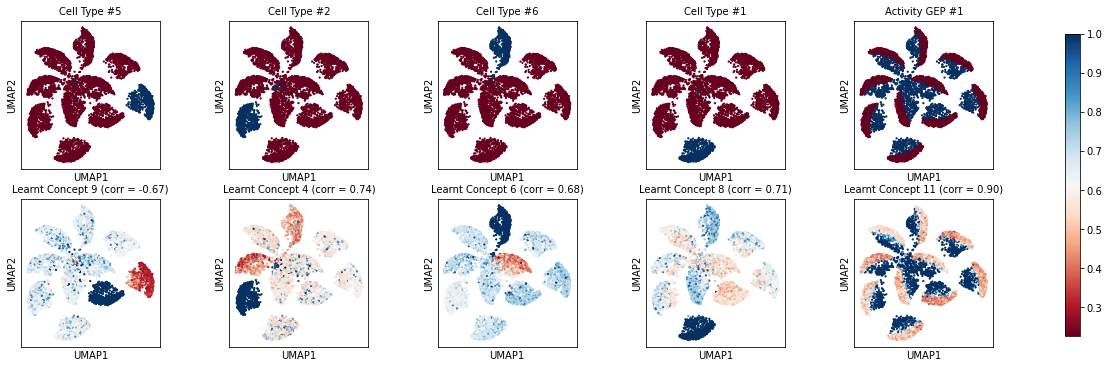




 **************************************** 



[WARNING] Assuming independence between features in TabCBM training.
Trial 2


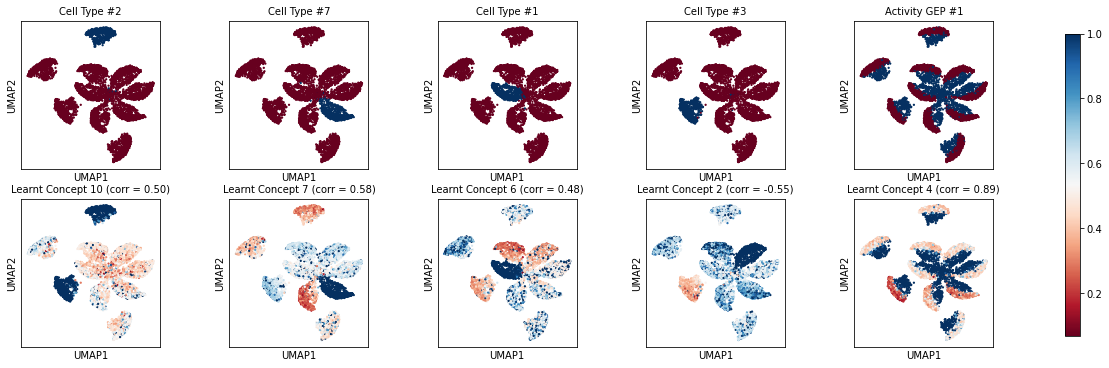




 **************************************** 





In [ ]:
import yaml
import tensorflow as tf

with open('results/sc_synth/sc_10_cell_types/rerun_config.yaml', 'r') as f:
    run_config = yaml.safe_load(f)

colormap = 'RdBu' #'RdYlBu'
fig_width = 7
fig_height = 3
dot_size = 6
font = 10
np.random.seed(2)
    
    
for trial in range(5):
    (
        X_train,
        X_test,
        y_train,
        y_test,
        c_train,
        c_test,
        ground_truth_concept_masks,
        adata
    ), _ = datasets.generate_synth_sc_data(
        seed=trial,
        include_adata=True,
        plot=False,
        **run_config.get('data_hyperparams', {}),
    )

    experiment_config = joblib.load(f'results/sc_synth/sc_10_cell_types/TabCBM/config_k_11_bn_True_partience_750_epochs_3000_trial_{trial}.joblib')
    extra_name = experiment_config.get('extra_name', "").format(**experiment_config)
    if extra_name:
        extra_name = "_" + extra_name
    extra_name = extra_name + f"_trial_{trial}"

    model = train_tabcbm.load_tabcbm(
        x_train=X_train.astype(np.float32),
        experiment_config=experiment_config,
        extra_name=extra_name,
    )
    preds, concept_scores = model.predict(adata.X)
    
    sample_projections = adata.obsm['X_umap']
    
    concepts = adata.obs['cell_type'].to_numpy() - 1
    concepts = (tf.one_hot(concepts, len(np.unique(concepts))).numpy()).astype(np.int32)
    concepts = np.concatenate(
        [concepts, np.array([x for x in adata.obs['has_act_program']])],
        axis=-1,
    )
    n_concepts = concepts.shape[-1]
    corr_mat = np.corrcoef(np.hstack([concept_scores, concepts]).T)[:n_concepts, n_concepts:]
    print("Trial", trial + 1)
#     for selected_concept in range(n_concepts):
#         fig, axs = plt.subplots(1, 2, figsize=(fig_width, fig_height))
#         axs[0].scatter(
#             sample_projections[:, 0],
#             sample_projections[:, 1],
#             marker='.',
#             c=concepts[:, selected_concept],
#             s=dot_size,
#             cmap=plt.cm.get_cmap(colormap),
#         )
#         axs[0].set_xticks([])
#         axs[0].set_yticks([])
#         axs[0].set_xlabel("UMAP1", fontsize=font)
#         axs[0].set_ylabel("UMAP2", fontsize=font)
#         axs[0].set_title(
# #             f"Ground-Truth Concept {selected_concept + 1}"
#             f"Cell Type #{selected_concept + 1}" if selected_concept < 10 else "Activity GEP #1",
#             fontsize=font,
#         )
#         axs[0].grid(False)



#         matched_learnt_concept = np.argmax(np.abs(corr_mat[:, selected_concept]))
#         activated_learnt_concepts = concept_scores[:, matched_learnt_concept]
#         thresh = np.percentile(activated_learnt_concepts, 90)
#         activated_learnt_concepts = (activated_learnt_concepts >= thresh).astype(np.int32)
#         out = axs[1].scatter(
#             sample_projections[:, 0],
#             sample_projections[:, 1],
#             marker='.',
#             c=concept_scores[:, matched_learnt_concept], #'black',
#             s=dot_size,
#             cmap=plt.cm.get_cmap(colormap),
#         )
#         fig.colorbar(out)

#         axs[1].set_xticks([])
#         axs[1].set_yticks([])
#         axs[1].set_xlabel("UMAP1", fontsize=font)
#         axs[1].set_ylabel("UMAP2", fontsize=font)
#         axs[1].set_title(
#             f"Learnt Concept {matched_learnt_concept + 1} (corr = {corr_mat[matched_learnt_concept, selected_concept]:.2f})",
#             fontsize=font,
#         )
#         axs[1].grid(False)
#         fig.suptitle("")
        
#         # And save the figure
#         plt.savefig(
#             os.path.join(
#                 "figures/",
#                 f"sc_concept_{selected_concept}_best_match_plot_trial_{trial}.png",
#             ),
#             bbox_inches='tight'
#         )
#         plt.savefig(
#             os.path.join(
#                 "figures/",
#                 f"sc_concept_{selected_concept}_best_match_plot_trial_{trial}.pdf",
#             ),
#             bbox_inches='tight'
#         )
#         plt.show()
    n_shown = 5
    fig, axs = plt.subplots(2, n_shown, figsize=(20, 6))
    for i, selected_concept in enumerate(list(np.random.permutation(n_concepts - 1))[:n_shown-1] + [10]):
        axs[0, i].scatter(
            sample_projections[:, 0],
            sample_projections[:, 1],
            marker='.',
            c=concepts[:, selected_concept],
            s=dot_size,
            cmap=plt.cm.get_cmap(colormap),
        )
        axs[0, i].set_xticks([])
        axs[0, i].set_yticks([])
        axs[0, i].set_xlabel("UMAP1", fontsize=font)
        axs[0, i].set_ylabel("UMAP2", fontsize=font)
        axs[0, i].set_title(
#             f"Ground-Truth Concept {selected_concept + 1}"
            f"Cell Type #{selected_concept + 1}" if selected_concept < 10 else "Activity GEP #1",
            fontsize=font,
        )
        axs[0, i].grid(False)



        matched_learnt_concept = np.argmax(np.abs(corr_mat[:, selected_concept]))
        activated_learnt_concepts = concept_scores[:, matched_learnt_concept]
        thresh = np.percentile(activated_learnt_concepts, 90)
        activated_learnt_concepts = (activated_learnt_concepts >= thresh).astype(np.int32)
        out = axs[1, i].scatter(
            sample_projections[:, 0],
            sample_projections[:, 1],
            marker='.',
            c=concept_scores[:, matched_learnt_concept], #'black',
            s=dot_size,
            cmap=plt.cm.get_cmap(colormap),
        )

        axs[1, i].set_xticks([])
        axs[1, i].set_yticks([])
        axs[1, i].set_xlabel("UMAP1", fontsize=font)
        axs[1, i].set_ylabel("UMAP2", fontsize=font)
        axs[1, i].set_title(
            f"Learnt Concept {matched_learnt_concept + 1} (corr = {corr_mat[matched_learnt_concept, selected_concept]:.2f})",
            fontsize=font,
        )
        axs[1, i].grid(False)
        
    fig.subplots_adjust(right=0.8, wspace=0.5)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
    fig.colorbar(out, cax=cbar_ax)
        
    # And save the figure
    plt.savefig(
        os.path.join(
            "figures/",
            f"sc_concept_random_selection_trial_{trial}.png",
        ),
        bbox_inches='tight'
    )
    plt.savefig(
        os.path.join(
            "figures/",
            f"sc_concept_random_selection_trial_{trial}.pdf",
        ),
        bbox_inches='tight'
    )
    plt.show()
    print("\n\n\n", "*" * 40, "\n\n\n")
    
    

Trial 1


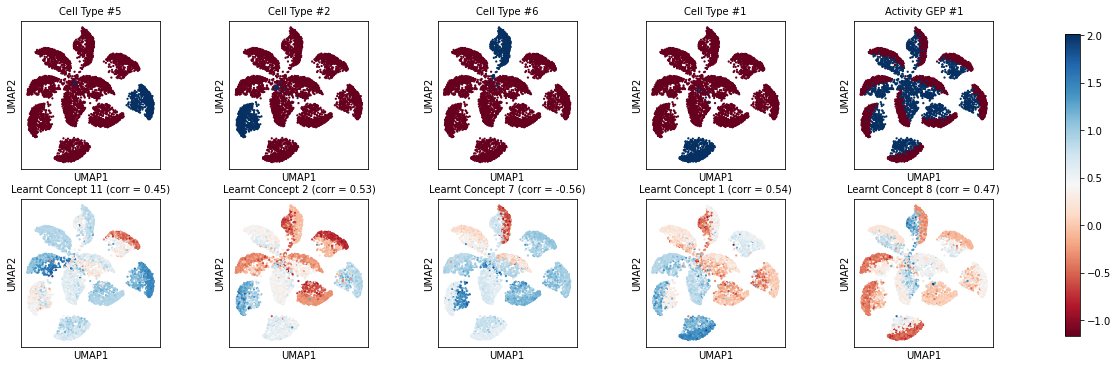




 **************************************** 





Trial 2


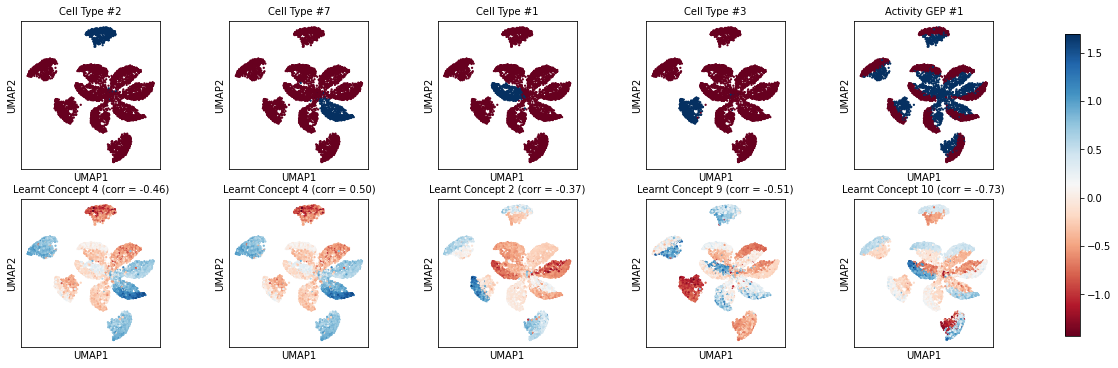




 **************************************** 





Trial 3


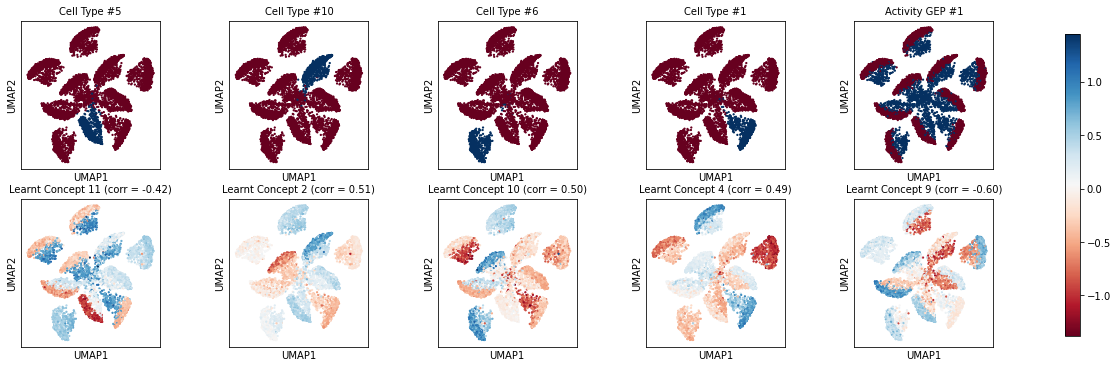




 **************************************** 





Trial 4


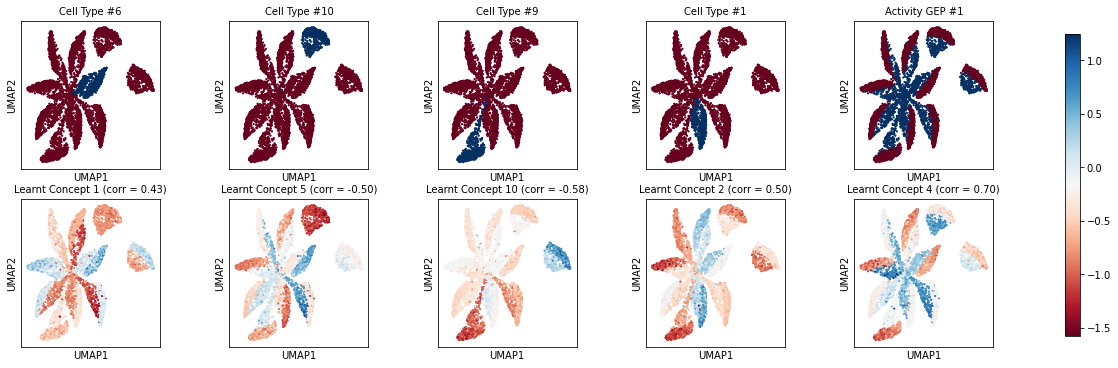




 **************************************** 





Trial 5


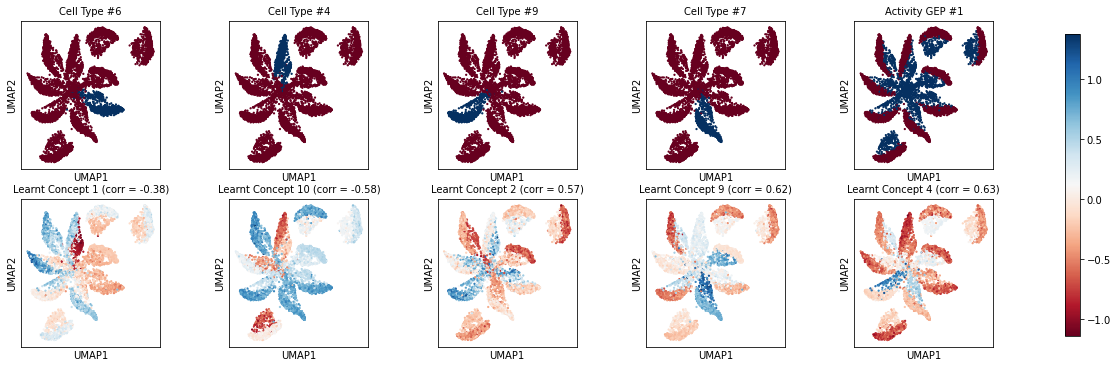




 **************************************** 





In [391]:
import yaml
import training.train_senn
import tensorflow as tf
import models.models as models

with open(f'{SYNTH_RESULTS}/sc_synth/sc_10_cell_types/rerun_config.yaml', 'r') as f:
    run_config = yaml.safe_load(f)

colormap = 'RdBu' #'RdYlBu'
fig_width = 7
fig_height = 3
dot_size = 6
font = 10
np.random.seed(2)
    
    
for trial in range(5):
    (
        X_train,
        X_test,
        y_train,
        y_test,
        c_train,
        c_test,
        ground_truth_concept_masks,
        adata
    ), _ = datasets.generate_synth_sc_data(
        seed=trial,
        include_adata=True,
        plot=False,
        **run_config.get('data_hyperparams', {}),
    )

    experiment_config = joblib.load(f'{SYNTH_RESULTS}/sc_synth/sc_10_cell_types/SENN/config_k_11_trial_{trial}.joblib')
    extra_name = experiment_config.get('extra_name', "").format(**experiment_config)
    if extra_name:
        extra_name = "_" + extra_name
    extra_name = extra_name + f"_trial_{trial}"
        
    encoder_path = os.path.join(
        experiment_config["results_dir"],
        f"models/encoder{extra_name}"
    )
    concept_encoder = tf.keras.models.load_model(encoder_path)
    concept_decoder = tf.keras.models.load_model(
        encoder_path.replace('/encoder_', '/decoder_')
    )
    coefficient_model = tf.keras.models.load_model(
        encoder_path.replace('/encoder_', '/coefficient_model_')
    )
    model = models.construct_senn_model(
        concept_encoder=concept_encoder,
        concept_decoder=concept_decoder,
        coefficient_model=coefficient_model,
        num_outputs=max(experiment_config["num_outputs"], 2),
        regularization_strength=experiment_config.get(
            "regularization_strength",
            0.1,
        ),
        learning_rate=experiment_config.get("learning_rate", 1e-3),
        sparsity_strength=experiment_config.get(
            "sparsity_strength",
            2e-5,
        ),
    )
    preds, (_, x_test_theta_class_scores) = model.predict(
        adata.X,
        batch_size=experiment_config["batch_size"],
    )
    concept_scores = training.train_senn.get_argmax_concept_explanations(
        preds,
        x_test_theta_class_scores,
    )
    
    sample_projections = adata.obsm['X_umap']
    
    concepts = adata.obs['cell_type'].to_numpy() - 1
    concepts = (tf.one_hot(concepts, len(np.unique(concepts))).numpy()).astype(np.int32)
    concepts = np.concatenate(
        [concepts, np.array([x for x in adata.obs['has_act_program']])],
        axis=-1,
    )
    n_concepts = concepts.shape[-1]
    corr_mat = np.corrcoef(np.hstack([concept_scores, concepts]).T)[:n_concepts, n_concepts:]
    print("Trial", trial + 1)
    n_shown = 5
    fig, axs = plt.subplots(2, n_shown, figsize=(20, 6))
    for i, selected_concept in enumerate(list(np.random.permutation(n_concepts - 1))[:n_shown-1] + [10]):
        axs[0, i].scatter(
            sample_projections[:, 0],
            sample_projections[:, 1],
            marker='.',
            c=concepts[:, selected_concept],
            s=dot_size,
            cmap=plt.cm.get_cmap(colormap),
        )
        axs[0, i].set_xticks([])
        axs[0, i].set_yticks([])
        axs[0, i].set_xlabel("UMAP1", fontsize=font)
        axs[0, i].set_ylabel("UMAP2", fontsize=font)
        axs[0, i].set_title(
            f"Cell Type #{selected_concept + 1}" if selected_concept < 10 else "Activity GEP #1",
            fontsize=font,
        )
        axs[0, i].grid(False)



        matched_learnt_concept = np.argmax(np.abs(corr_mat[:, selected_concept]))
        activated_learnt_concepts = concept_scores[:, matched_learnt_concept]
        thresh = np.percentile(activated_learnt_concepts, 90)
        activated_learnt_concepts = (activated_learnt_concepts >= thresh).astype(np.int32)
        out = axs[1, i].scatter(
            sample_projections[:, 0],
            sample_projections[:, 1],
            marker='.',
            c=concept_scores[:, matched_learnt_concept], #'black',
            s=dot_size,
            cmap=plt.cm.get_cmap(colormap),
        )

        axs[1, i].set_xticks([])
        axs[1, i].set_yticks([])
        axs[1, i].set_xlabel("UMAP1", fontsize=font)
        axs[1, i].set_ylabel("UMAP2", fontsize=font)
        axs[1, i].set_title(
            f"Learnt Concept {matched_learnt_concept + 1} (corr = {corr_mat[matched_learnt_concept, selected_concept]:.2f})",
            fontsize=font,
        )
        axs[1, i].grid(False)
        
    fig.subplots_adjust(right=0.8, wspace=0.5)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
    fig.colorbar(out, cax=cbar_ax)
        
    # And save the figure
    plt.savefig(
        os.path.join(
            "figures/",
            f"sc_concept_random_selection_senn_trial_{trial}.png",
        ),
        bbox_inches='tight'
    )
    plt.savefig(
        os.path.join(
            "figures/",
            f"sc_concept_random_selection_senn_trial_{trial}.pdf",
        ),
        bbox_inches='tight'
    )
    plt.show()
    print("\n\n\n", "*" * 40, "\n\n\n")
    
    

Trial 1


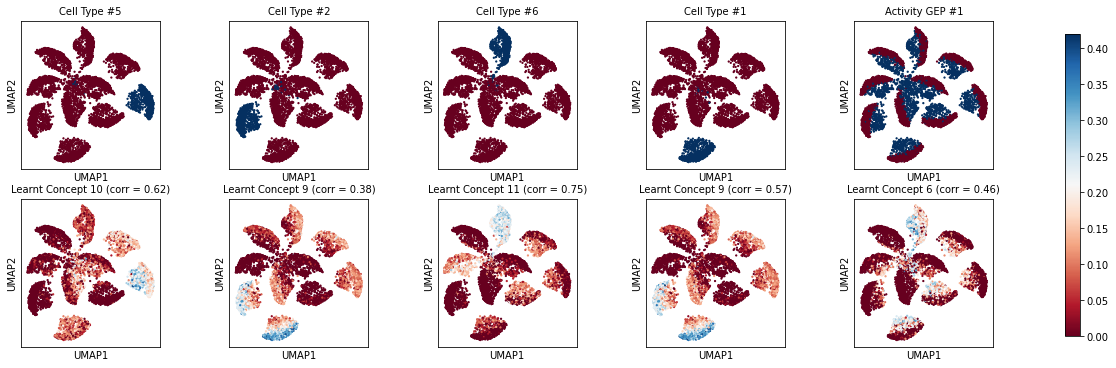




 **************************************** 





Trial 2


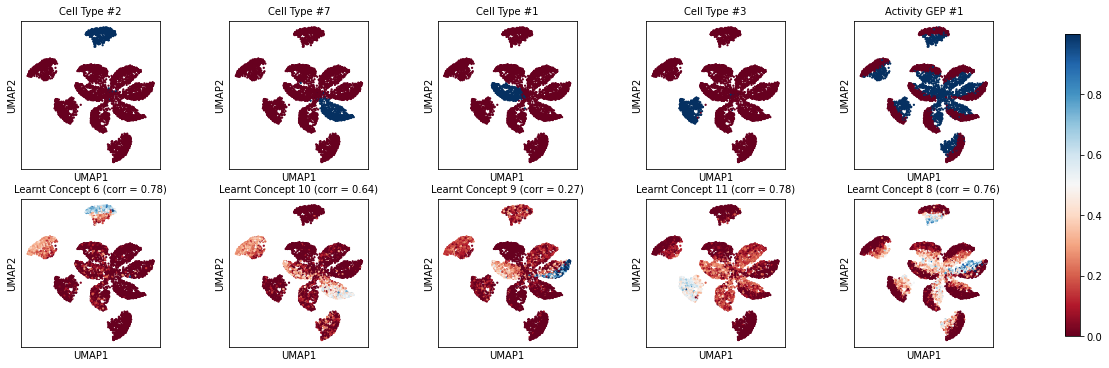




 **************************************** 





Trial 3


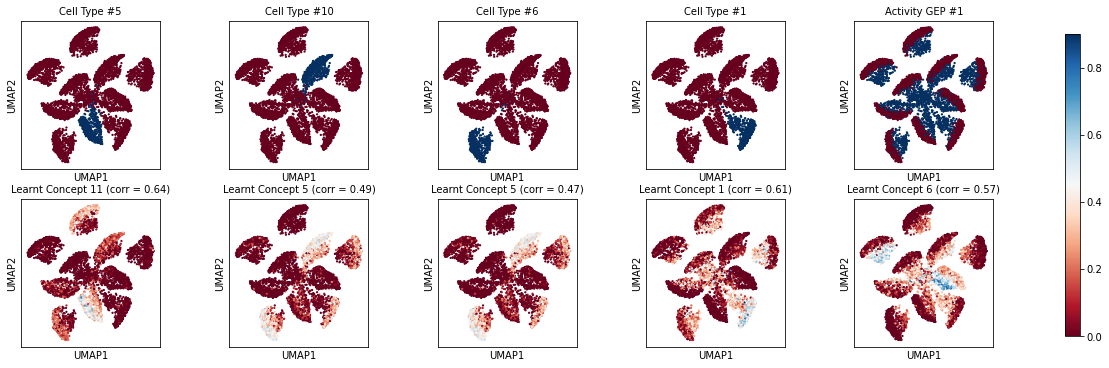




 **************************************** 





Trial 4


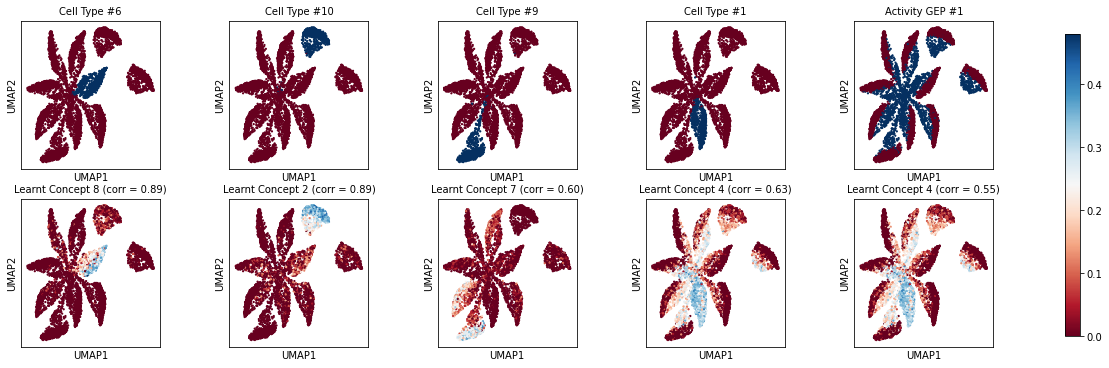




 **************************************** 





Trial 5


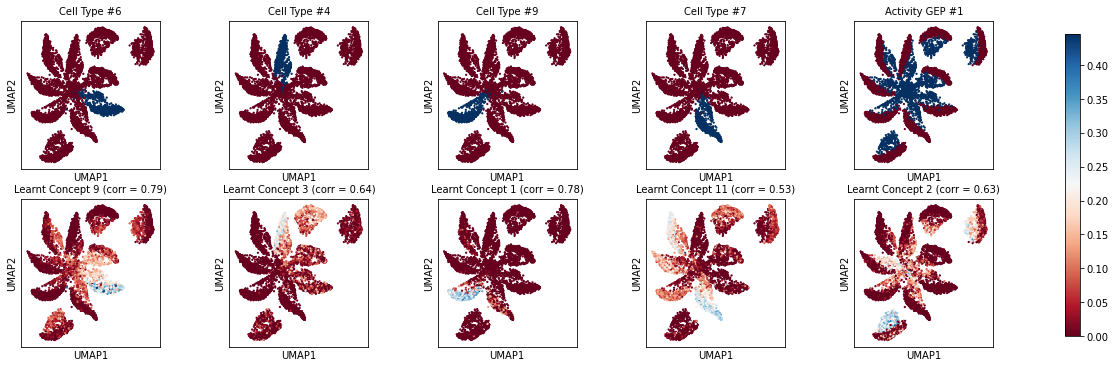




 **************************************** 





In [397]:
import yaml
import concepts_xai.methods.OCACE.topicModel as CCD
import tensorflow as tf
import models.models as models

with open(f'{SYNTH_RESULTS}/sc_synth/sc_10_cell_types/rerun_config.yaml', 'r') as f:
    run_config = yaml.safe_load(f)

colormap = 'RdBu' #'RdYlBu'
fig_width = 7
fig_height = 3
dot_size = 6
font = 10
np.random.seed(2)
    
    
for trial in range(5):
    (
        X_train,
        X_test,
        y_train,
        y_test,
        c_train,
        c_test,
        ground_truth_concept_masks,
        adata
    ), _ = datasets.generate_synth_sc_data(
        seed=trial,
        include_adata=True,
        plot=False,
        **run_config.get('data_hyperparams', {}),
    )

    experiment_config = joblib.load(f'{SYNTH_RESULTS}/sc_synth/sc_10_cell_types/CCD/config_k_11_trial_{trial}.joblib')
    extra_name = experiment_config.get('extra_name', "").format(**experiment_config)
    if extra_name:
        extra_name = "_" + extra_name
    extra_name = extra_name + f"_trial_{trial}"
    
    
    encoder_path = os.path.join(
        experiment_config["results_dir"],
        f"models/encoder{extra_name}"
    )
    decoder_path = os.path.join(
        experiment_config["results_dir"],
        f"models/decoder{extra_name}"
    )
    encoder = tf.keras.models.load_model(encoder_path)
    decoder = tf.keras.models.load_model(decoder_path)
    end_to_end_model, encoder, decoder = models.construct_end_to_end_model(
        input_shape=experiment_config["input_shape"],
        num_outputs=experiment_config["num_outputs"],
        learning_rate=experiment_config["learning_rate"],
        encoder=encoder,
        decoder=decoder,
    )
    def derp(y_true, y_pred):
        return tf.keras.metrics.binary_accuracy(
            tf.cast(y_true, tf.int32),
            tf.cast(tf.math.sigmoid(y_pred) >= 0.5, tf.int32)
        )
    topic_model = CCD.TopicModel(
        concepts_to_labels_model=decoder,
        n_channels=experiment_config["latent_dims"],
        n_concepts=experiment_config['n_concepts'],
        threshold=experiment_config.get("threshold", 0.5),
        loss_fn=end_to_end_model.loss,
        top_k=experiment_config.get("top_k", 32),
        lambda1=experiment_config.get("lambda1", 0.1),
        lambda2=experiment_config.get("lambda2", 0.1),
        seed=42,
        eps=experiment_config.get("eps", 1e-5),
        data_format=experiment_config.get(
            "data_format",
            "channels_last"
        ),
        allow_gradient_flow_to_c2l=experiment_config.get(
            'allow_gradient_flow_to_c2l',
            False,
        ),
        acc_metric=(
            (
                lambda y_true, y_pred: tf.keras.metrics.sparse_categorical_accuracy(
                    y_true,
                    y_pred,
                )
            ) if experiment_config["num_outputs"] > 1 else derp
        ),
    )
    topic_model.compile(
        optimizer=tf.keras.optimizers.Adam(
            experiment_config.get("learning_rate", 1e-3),
        )
    )
    
    ccd_g_model_path = os.path.join(
        experiment_config["results_dir"],
        f"models/ccd_g_model{extra_name}"
    )
    topic_model.g_model = tf.keras.models.load_model(ccd_g_model_path)
    topic_model.topic_vector.assign(np.load(
        ccd_g_model_path.replace('g_model', 'topic_vector_n') + ".npy"
    ))
        
    test_encodings = encoder.predict(
        adata.X,
        batch_size=experiment_config["batch_size"],
    )
    preds, concept_scores = topic_model.predict(
        test_encodings,
        batch_size=experiment_config["batch_size"],
    )
    
    sample_projections = adata.obsm['X_umap']
    
    concepts = adata.obs['cell_type'].to_numpy() - 1
    concepts = (tf.one_hot(concepts, len(np.unique(concepts))).numpy()).astype(np.int32)
    concepts = np.concatenate(
        [concepts, np.array([x for x in adata.obs['has_act_program']])],
        axis=-1,
    )
    n_concepts = concepts.shape[-1]
    corr_mat = np.corrcoef(np.hstack([concept_scores, concepts]).T)[:n_concepts, n_concepts:]
    print("Trial", trial + 1)
    n_shown = 5
    fig, axs = plt.subplots(2, n_shown, figsize=(20, 6))
    for i, selected_concept in enumerate(list(np.random.permutation(n_concepts - 1))[:n_shown-1] + [10]):
        axs[0, i].scatter(
            sample_projections[:, 0],
            sample_projections[:, 1],
            marker='.',
            c=concepts[:, selected_concept],
            s=dot_size,
            cmap=plt.cm.get_cmap(colormap),
        )
        axs[0, i].set_xticks([])
        axs[0, i].set_yticks([])
        axs[0, i].set_xlabel("UMAP1", fontsize=font)
        axs[0, i].set_ylabel("UMAP2", fontsize=font)
        axs[0, i].set_title(
            f"Cell Type #{selected_concept + 1}" if selected_concept < 10 else "Activity GEP #1",
            fontsize=font,
        )
        axs[0, i].grid(False)



        matched_learnt_concept = np.argmax(np.abs(corr_mat[:, selected_concept]))
        activated_learnt_concepts = concept_scores[:, matched_learnt_concept]
        thresh = np.percentile(activated_learnt_concepts, 90)
        activated_learnt_concepts = (activated_learnt_concepts >= thresh).astype(np.int32)
        out = axs[1, i].scatter(
            sample_projections[:, 0],
            sample_projections[:, 1],
            marker='.',
            c=concept_scores[:, matched_learnt_concept], #'black',
            s=dot_size,
            cmap=plt.cm.get_cmap(colormap),
        )

        axs[1, i].set_xticks([])
        axs[1, i].set_yticks([])
        axs[1, i].set_xlabel("UMAP1", fontsize=font)
        axs[1, i].set_ylabel("UMAP2", fontsize=font)
        axs[1, i].set_title(
            f"Learnt Concept {matched_learnt_concept + 1} (corr = {corr_mat[matched_learnt_concept, selected_concept]:.2f})",
            fontsize=font,
        )
        axs[1, i].grid(False)
        
    fig.subplots_adjust(right=0.8, wspace=0.5)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
    fig.colorbar(out, cax=cbar_ax)
        
    # And save the figure
    plt.savefig(
        os.path.join(
            "figures/",
            f"sc_concept_random_selection_ccd_trial_{trial}.png",
        ),
        bbox_inches='tight'
    )
    plt.savefig(
        os.path.join(
            "figures/",
            f"sc_concept_random_selection_ccd_trial_{trial}.pdf",
        ),
        bbox_inches='tight'
    )
    plt.show()
    print("\n\n\n", "*" * 40, "\n\n\n")
    
    

# scRNA Dataset Visualization

In [ ]:
import yaml
import concepts_xai.methods.OCACE.topicModel as CCD
import tensorflow as tf
import models.models as models

colormap = 'RdBu' #'RdYlBu'
fig_width = 7
fig_height = 3
dot_size = 6
font = 10
np.random.seed(2)

with open(f'{SYNTH_RESULTS}/sc_synth/sc_10_cell_types/rerun_config.yaml', 'r') as f:
    run_config = yaml.safe_load(f)
    
for trial in range(5):
    (
        X_train,
        X_test,
        y_train,
        y_test,
        c_train,
        c_test,
        ground_truth_concept_masks,
        adata
    ), _ = datasets.generate_synth_sc_data(
        seed=trial,
        include_adata=True,
        plot=False,
        **run_config.get('data_hyperparams', {}),
    )

    sample_projections = adata.obsm['X_umap']

    concepts = adata.obs['cell_type'].to_numpy() - 1
    concepts = (tf.one_hot(concepts, len(np.unique(concepts))).numpy()).astype(np.int32)
    concepts = np.concatenate(
        [concepts, np.array([x for x in adata.obs['has_act_program']])],
        axis=-1,
    )
    n_concepts = concepts.shape[-1]
    print("Trial", trial + 1)
    fig = plt.figure(figsize=(20, 6))
    gs = fig.add_gridspec(2, (n_concepts - 1)//2 + 2)
    for selected_concept in range(n_concepts):
        n_cols = (n_concepts - 1)//2
        row = selected_concept // n_cols
        col = selected_concept % n_cols
        if selected_concept < n_concepts - 1:
            ax = fig.add_subplot(gs[row, col])
        else:
            ax = fig.add_subplot(gs[:, -2:])
        ax.scatter(
            sample_projections[:, 0],
            sample_projections[:, 1],
            marker='.',
            c=concepts[:, selected_concept],
            s=dot_size,
            cmap=plt.cm.get_cmap(colormap),
        )
        ax.set_xticks([])
        ax.set_yticks([])
        if selected_concept != n_concepts - 1:
            if col == 0:
                ax.set_ylabel("UMAP2", fontsize=font)
            if row == 1:
                ax.set_xlabel("UMAP1", fontsize=font)
        else:
            ax.set_xlabel("UMAP1", fontsize=font)
            ax.set_ylabel("UMAP2", fontsize=font)
        ax.set_title(
            f"Cell Type #{selected_concept + 1}" if selected_concept < 10 else "Activity GEP #1",
            fontsize=font,
        )
        ax.grid(False)
        
    fig.subplots_adjust(right=0.8, wspace=0.2)
#     cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
#     fig.colorbar(out, cax=cbar_ax)
        
    # And save the figure
    plt.savefig(
        os.path.join(
            "figures/",
            f"sc_cell_types_trial_{trial}.png",
        ),
        bbox_inches='tight'
    )
    plt.savefig(
        os.path.join(
            "figures/",
            f"sc_cell_types_trial_{trial}.pdf",
        ),
        bbox_inches='tight'
    )
    plt.show()
    print("\n\n\n", "*" * 40, "\n\n\n")

# Interventions

best_ind_alignment_auc = (0.6144988355141129, 0.10422447613280532)
thresh = 0.7 frac_data = 0.25 ds_name = single_cell percent = 0 model_name = TabCBM x_vals = [0 1 2] y_means = [93.66460675 95.41614963 97.24707502] y_stds = [1.40536995 3.66387697 0.        ]
best_ind_alignment_auc = (0.6339483047604348, 0.3009629050477152)
thresh = 0.7 frac_data = 0.25 ds_name = single_cell percent = 0.25 model_name = TabCBM x_vals = [0 1 2 3 4 5 6] y_means = [87.19251777 91.22960906 93.81279986 94.04979129 93.99455881 95.56769185
 93.59944942] y_stds = [2.23915175 2.72611087 3.06079942 3.06718505 3.43517413 1.96824244
 0.        ]
best_ind_alignment_auc = (0.7553775209857023, 0.21484958901810464)
thresh = 0.7 frac_data = 0.25 ds_name = single_cell percent = 0.5 model_name = TabCBM x_vals = [0 1 2 3 4 5 6 7 8] y_means = [88.34940684 92.28474209 96.7599554  97.7785243  97.79499662 97.79499662
 99.00545639 99.24294563 99.24294563] y_stds = [3.02749835 3.45396737 1.08459522 1.0020749  1.0215903  1.021590

best_ind_alignment_auc = (0.9816684668601295, 0.014612958294488363)
thresh = 0.7 frac_data = 1 ds_name = synth_nonlin percent = 0.75 model_name = TabCBM x_vals = [0 1 2] y_means = [ 94.7    99.116 100.   ] y_stds = [0.18499249 0.73698002 0.        ]
best_ind_alignment_auc = (0.9752780826975733, 0.006191966942245109)
thresh = 0.7 frac_data = 1 ds_name = synth_linear percent = 0 model_name = TabCBM x_vals = [0 1 2] y_means = [ 99.84   99.984 100.   ] y_stds = [0.05734884 0.00679869 0.        ]
best_ind_alignment_auc = (0.9924424029562235, 0.007369853158010368)
thresh = 0.7 frac_data = 1 ds_name = synth_linear percent = 0.25 model_name = TabCBM x_vals = [0 1 2] y_means = [ 99.42        99.93733333 100.        ] y_stds = [0.47730726 0.04981744 0.        ]
best_ind_alignment_auc = (0.9924424029562235, 0.007369853158010368)
thresh = 0.7 frac_data = 1 ds_name = synth_linear percent = 0.5 model_name = TabCBM x_vals = [0 1 2] y_means = [ 99.42        99.93733333 100.        ] y_stds = [0.477307

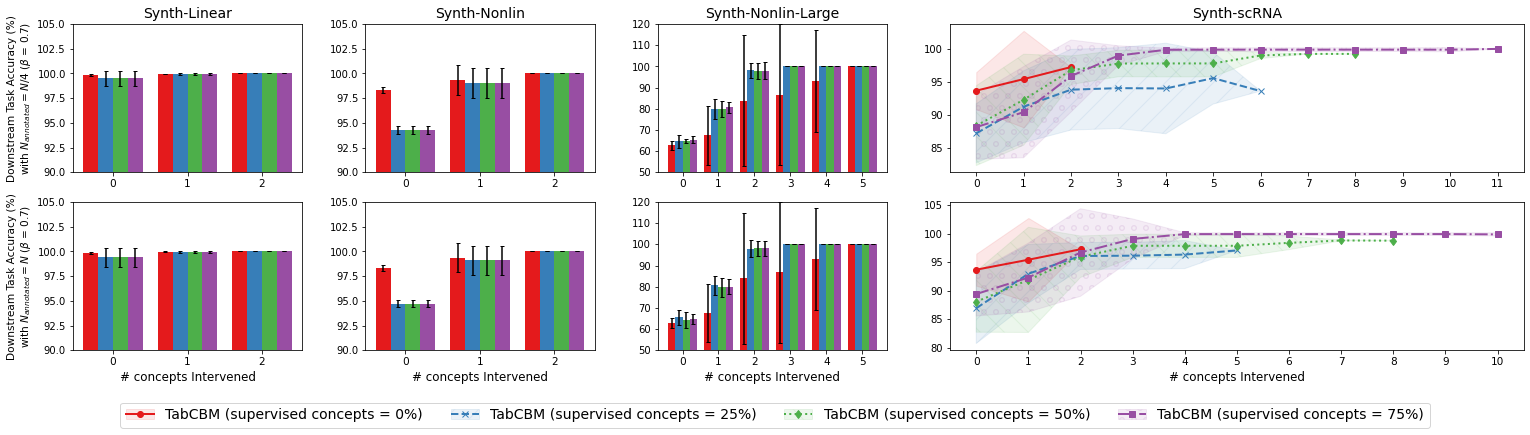

best_ind_alignment_auc = (0.6144988355141129, 0.10422447613280532)
thresh = 0.75 frac_data = 0.25 ds_name = single_cell percent = 0 model_name = TabCBM x_vals = [0 1] y_means = [93.66460675 95.68318335] y_stds = [1.40536995 3.79671757]
best_ind_alignment_auc = (0.6339483047604348, 0.3009629050477152)
thresh = 0.75 frac_data = 0.25 ds_name = single_cell percent = 0.25 model_name = TabCBM x_vals = [0 1 2 3 4 5 6] y_means = [87.19251777 91.87242583 95.16444254 94.93038646 95.80031462 95.56769185
 93.59944942] y_stds = [2.23915175 4.03201847 1.48193821 1.67119469 1.64038986 1.96824244
 0.        ]
best_ind_alignment_auc = (0.7553775209857023, 0.21484958901810464)
thresh = 0.75 frac_data = 0.25 ds_name = single_cell percent = 0.5 model_name = TabCBM x_vals = [0 1 2 3 4 5 6 7 8] y_means = [88.34940684 91.42173606 96.36615691 97.79499662 97.79499662 97.79499662
 99.00545639 99.24294563 99.24294563] y_stds = [3.02749835 3.15719205 1.25628761 1.0215903  1.0215903  1.0215903
 0.23748924 0.      

best_ind_alignment_auc = (0.9924424029562235, 0.007369853158010368)
thresh = 0.75 frac_data = 1 ds_name = synth_linear percent = 0.25 model_name = TabCBM x_vals = [0 1 2] y_means = [ 99.42        99.94533333 100.        ] y_stds = [0.47730726 0.03330666 0.        ]
best_ind_alignment_auc = (0.9924424029562235, 0.007369853158010368)
thresh = 0.75 frac_data = 1 ds_name = synth_linear percent = 0.5 model_name = TabCBM x_vals = [0 1 2] y_means = [ 99.42        99.94533333 100.        ] y_stds = [0.47730726 0.03330666 0.        ]
best_ind_alignment_auc = (0.9924424029562235, 0.007369853158010368)
thresh = 0.75 frac_data = 1 ds_name = synth_linear percent = 0.75 model_name = TabCBM x_vals = [0 1 2] y_means = [ 99.42        99.94533333 100.        ] y_stds = [0.47730726 0.03330666 0.        ]
['TabCBM (supervised concepts = 0%)', 'TabCBM (supervised concepts = 25%)', 'TabCBM (supervised concepts = 50%)', 'TabCBM (supervised concepts = 75%)']


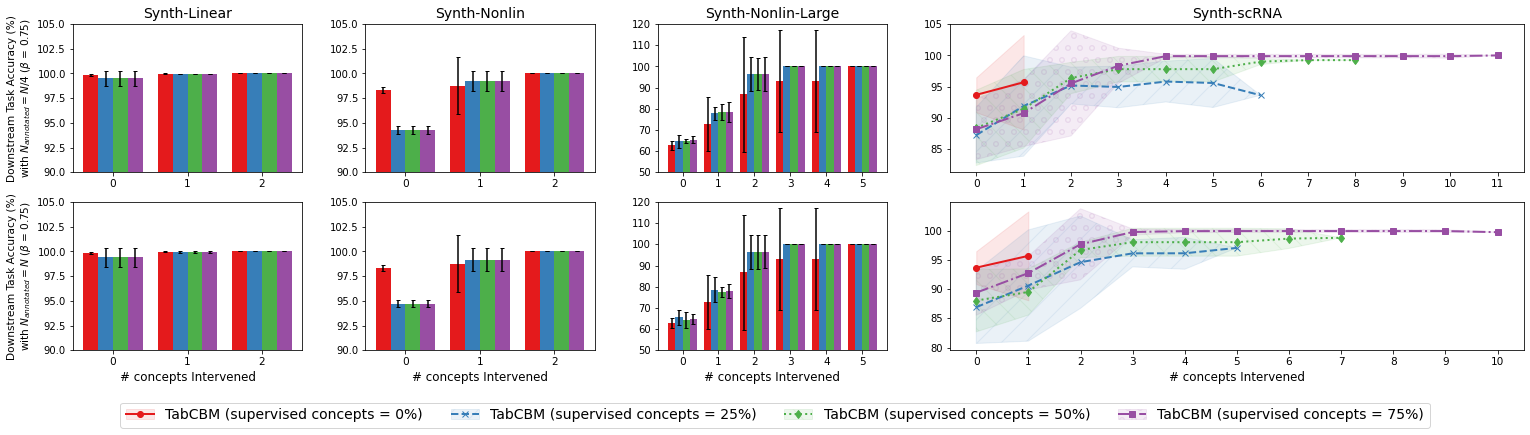

best_ind_alignment_auc = (0.6144988355141129, 0.10422447613280532)
thresh = 0.8 frac_data = 0.25 ds_name = single_cell percent = 0 model_name = TabCBM x_vals = [0 1] y_means = [93.66460675 97.53005722] y_stds = [1.40536995 0.98189359]
best_ind_alignment_auc = (0.6339483047604348, 0.3009629050477152)
thresh = 0.8 frac_data = 0.25 ds_name = single_cell percent = 0.25 model_name = TabCBM x_vals = [0 1 2 3 4 5] y_means = [87.19251777 91.95499887 93.78526012 93.80168722 93.91914922 97.53593429] y_stds = [2.23915175 1.70527302 3.28200984 3.30048404 4.24839128 0.        ]
best_ind_alignment_auc = (0.7553775209857023, 0.21484958901810464)
thresh = 0.8 frac_data = 0.25 ds_name = single_cell percent = 0.5 model_name = TabCBM x_vals = [0 1 2 3 4 5 6 7] y_means = [88.34940684 91.01991432 97.6152279  97.76731663 97.76731663 97.76731663
 98.96765313 98.96765313] y_stds = [3.02749835 2.67804788 1.0183968  0.97755758 0.97755758 0.97755758
 0.         0.        ]
best_ind_alignment_auc = (0.88817272436

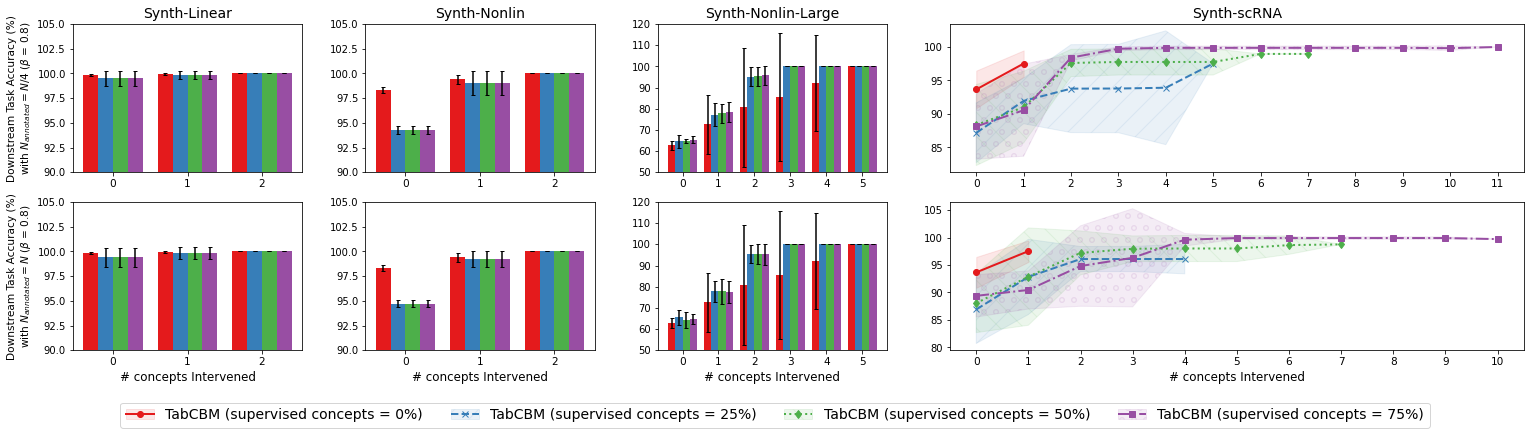

best_ind_alignment_auc = (0.6144988355141129, 0.10422447613280532)
thresh = 0.85 frac_data = 0.25 ds_name = single_cell percent = 0 model_name = TabCBM x_vals = [0 1] y_means = [93.66460675 97.53005722] y_stds = [1.40536995 0.98189359]
best_ind_alignment_auc = (0.6339483047604348, 0.3009629050477152)
thresh = 0.85 frac_data = 0.25 ds_name = single_cell percent = 0.25 model_name = TabCBM x_vals = [0 1 2 3 4 5] y_means = [87.19251777 89.97511906 93.72137793 94.09074434 96.90074723 97.53593429] y_stds = [2.23915175 3.72989505 2.96906701 2.80141194 0.63518706 0.        ]
best_ind_alignment_auc = (0.7553775209857023, 0.21484958901810464)
thresh = 0.85 frac_data = 0.25 ds_name = single_cell percent = 0.5 model_name = TabCBM x_vals = [0 1 2 3 4 5 6] y_means = [88.34940684 90.29355806 96.63957598 97.69849351 97.69849351 97.69849351
 98.62353751] y_stds = [3.02749835 2.32156571 1.30607327 0.89963521 0.89963521 0.89963521
 0.        ]
best_ind_alignment_auc = (0.8881727243629748, 0.1838118443683

best_ind_alignment_auc = (0.9816684668601295, 0.014612958294488363)
thresh = 0.85 frac_data = 1 ds_name = synth_nonlin percent = 0.75 model_name = TabCBM x_vals = [0 1 2] y_means = [ 94.7   98.58 100.  ] y_stds = [0.18499249 0.93504605 0.        ]
best_ind_alignment_auc = (0.9752780826975733, 0.006191966942245109)
thresh = 0.85 frac_data = 1 ds_name = synth_linear percent = 0 model_name = TabCBM x_vals = [0 1 2] y_means = [ 99.84        99.91866667 100.        ] y_stds = [0.05734884 0.09096031 0.        ]
best_ind_alignment_auc = (0.9924424029562235, 0.007369853158010368)
thresh = 0.85 frac_data = 1 ds_name = synth_linear percent = 0.25 model_name = TabCBM x_vals = [0 1 2] y_means = [ 99.42   99.856 100.   ] y_stds = [0.47730726 0.08236504 0.        ]
best_ind_alignment_auc = (0.9924424029562235, 0.007369853158010368)
thresh = 0.85 frac_data = 1 ds_name = synth_linear percent = 0.5 model_name = TabCBM x_vals = [0 1 2] y_means = [ 99.42   99.856 100.   ] y_stds = [0.47730726 0.08236504 

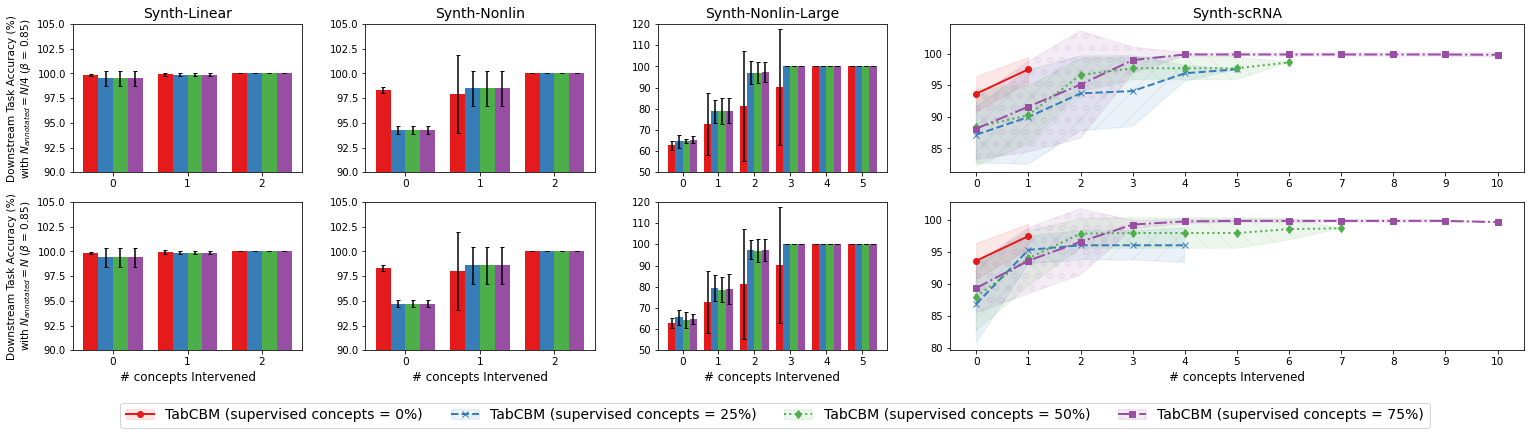

In [272]:
ds_names = [
    ('single_cell', 'Synth-scRNA', 11),
    ('synth_nonlin_complex', 'Synth-Nonlin-Large', 5),
    ('synth_nonlin', 'Synth-Nonlin', 2),
    ('synth_linear', 'Synth-Linear', 2),
]
percent_styles = [
    (0, 'solid', 'o', None),
    (0.25, 'dashed', 'x', '/'),
    (0.5, 'dotted', 'd', '\\'),
    (0.75, 'dashdot', 's', 'o'),
#     (1, 'dashdot', 's', 'o'),
]
model_names = [
      'TabCBM',
]
frac_data_list = [0.25, 1]
threshs = [0.7, 0.75, 0.8, 0.85] #[0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.60, 0.65, 0.7, 0.75,0.8, 0.85]
for thresh in threshs:
    labels = []
    handles = []
    alpha = 0.1
    font = 14
    bar_width = 0.2
    color_map = {}
    clrs = sns.color_palette("Set1", 10)
    fig, axs = plt.subplots(
        len(frac_data_list),
        len(ds_names),
        figsize=(26, 3*len(frac_data_list)),
        gridspec_kw={'width_ratios': [1, 1, 1, 2.5]}
    )
    
    for frac_idx, frac_data in enumerate(frac_data_list):
        for ds_idx, (ds_name, ds_pretty_name, n_concepts) in enumerate(ds_names):
            ax = axs[frac_idx, len(ds_names) - ds_idx - 1]
            for model_name in model_names:
                seen = set()
                for idx, (percent, line_style, mark_style, hatch_style) in enumerate(
                    percent_styles
                ):
                    sup_concepts = int(np.floor(n_concepts * percent))
                    og_frac_data = frac_data
                    curr_metrics = results[ds_name][model_name]
                    if frac_data == 0 or percent == 0:
                        # Then because supervision is not provided, we will
                        # simply always use the 0% supervised dataset for consistency
                        curr_metrics = curr_metrics[(0, 0)]
                    elif (sup_concepts, frac_data) in curr_metrics:
                        curr_metrics = curr_metrics[(sup_concepts, frac_data)]
                    elif (sup_concepts + 1, frac_data) in curr_metrics:
                        curr_metrics = curr_metrics[(sup_concepts + 1, frac_data)]
                    elif (sup_concepts - 1, frac_data) in curr_metrics:
                        curr_metrics = curr_metrics[(sup_concepts - 1, frac_data)]
                    else:
                        continue
                    key = (model_name, percent)
                    if key not in color_map:
                        color_map[key] = clrs[len(color_map)]
                    color = color_map[key]
                    y_means = []
                    y_stds = []
                    x_vals = []
                    print('best_ind_alignment_auc =', curr_metrics['best_ind_alignment_auc'])
                    for concept_ints in range(n_concepts + 1):
                        if concept_ints == 0:
                            mean, std = curr_metrics['acc']
                        elif f'acc_intervention_{concept_ints}_thresh_{thresh}' in curr_metrics:
                            mean, std = curr_metrics[f'acc_intervention_{concept_ints}_thresh_{thresh}']
                        else:
                            continue
                        y_means.append(mean)
                        y_stds.append(std)
                        x_vals.append(concept_ints)
                    x_vals = np.array(x_vals)
                    y_means = 100 * np.array(y_means)
                    y_stds = 100 * np.array(y_stds)
                    print("thresh =", thresh, "frac_data =", frac_data, "ds_name =", ds_name, "percent =", percent, "model_name =", model_name, "x_vals =", x_vals, "y_means =", y_means, "y_stds =", y_stds)
                    if n_concepts > 5:
                        p1 = ax.plot(
                            x_vals,
                            y_means,
                            color=color,
                            linestyle=line_style,
                            linewidth=2,
                            marker=mark_style,
                        )
                        ax.fill_between(
                            x_vals,
                            y_means - 2*y_stds,
                            y_means + 2*y_stds,
                            color=color,
                            alpha=alpha,
                            hatch=hatch_style,
                        )
                    else:
                        p1 = ax.bar(
                            x=x_vals + idx * bar_width,
                            height=y_means,
                            width=bar_width,
                            align='edge',
                            color=color,
                            linewidth=2,
                            capsize=2,
                            yerr=2*y_stds,
                        )
                        if n_concepts == 2:
                            ax.set_ylim((90, 105)) #(65, 120))
                        elif n_concepts == 5:
                            ax.set_ylim((50, 120)) #((75, 110))
                        else:
                            ax.set_ylim((80, 105)) #((75, 110))
                    if frac_idx == 0:
                        ax.set_title(ds_pretty_name, fontsize=font)
                    if frac_idx == len(frac_data_list) - 1:
                        ax.set_xlabel('# concepts Intervened', fontsize=(0.85 * font))
                    if n_concepts > 5:
                        ax.set_xticks(
                            x_vals,
                            [f'{int(j)}' for j in x_vals], fontsize=(0.75 * font)
                        )
                    else:
                        ax.set_xticks(
                            x_vals + len(percent_styles)//2 * bar_width,
                            [f'{int(j)}' for j in x_vals], fontsize=(0.75 * font)
                        )
                    
                    if len(ds_names) - ds_idx - 1 == 0:
                        ax.set_ylabel(
                            (
                                f'Downstream Task Accuracy (%)\nwith $N_{{annotated}} = N/4$ ($\\beta$ = {thresh})' if frac_idx == 0
                                else f'Downstream Task Accuracy (%)\nwith $N_{{annotated}} = N$ ($\\beta$ = {thresh})'
                            ),
                            fontsize=(0.75 * font),
                        )
                    p2 = ax.fill(np.NaN, np.NaN, color=color, hatch=hatch_style, alpha=alpha)
                    name = f"{model_name} (supervised concepts = {int(percent * 100)}%)"
                    if name not in labels:
                        handles.append((p2[0], p1[0]))
                        labels.append(f"{model_name} (supervised concepts = {int(percent * 100)}%)")
    print(labels)
    labels = sorted(enumerate(labels), key=lambda x: int(x[1][x[1].index("=") + 1:-2].strip()))
    inds = list(map(lambda x: x[0], labels))
    labels = list(map(lambda x: x[1], labels))
    handles = [handles[x] for x in inds]
    lgd = fig.legend(
        handles,
        labels,
        fontsize=font,
        loc='upper center',
        bbox_to_anchor=(0.5,0.02),
        ncol=4,
    )

    plt.savefig(
        os.path.join(
            "figures/",
            f"concept_interventions_trhesh_{thresh}.png",
        ),
        bbox_extra_artists=(lgd,),
        bbox_inches='tight'
    )
    plt.savefig(
        os.path.join(
            "figures/",
            f"concept_interventions_trhesh_{thresh}.pdf",
        ),
        bbox_extra_artists=(lgd,),
        bbox_inches='tight'
    )
    plt.show()